<a href="https://colab.research.google.com/github/petr-ngn/CNN_Real_Estate_Offices_Amenities_Listing/blob/main/CNN_Real_Estate_Offices_Amenities_Listing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-label Classificiation of real-estate offices' amenities using Convolutional Neural Networks (CNN)**

*Author:* **Petr Nguyen**

- *Collaborators: Ilya Tsakunov, Peter Kachnic, Adrián Harvan, Katerina Nekvindova, Simona Dohova, Marco Vezzola*

Installing and importing relevant libraries and modules

In [1]:
!pip install keras-tuner
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.5 MB/s 
     |████████████████████████████████| 1.6 MB 36.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.5 MB/s 


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
import kerastuner as kt
import visualkeras
from google.colab import drive
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
pd.set_option('display.max_colwidth', 400)
tf.get_logger().setLevel('ERROR')

Mounting the files from Google Drive
- this will not work for other viewers, since it's not possible to mount files from someone else's Google Drive.

In [3]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Input parameters' initialization

In [4]:
seed = 42
num_train_offices = 300
num_valid_offices = 79
num_test_offices = 78
num_train_valid_offices = num_train_offices + num_valid_offices
dim_size = 100
dim_tuple = (dim_size, dim_size, 3)
directory_path = '/content/gdrive/MyDrive/office_data/'
filename = 'office_data_processed_20221203.csv'

Setting a working directory path

In [5]:
os.chdir(directory_path)

##**Data loading and preprocessing**

Reading and processing the raw csv file containing the labels for each office.

In [6]:
def read_prep_csv(filename):

    #removing useless columns
    df = pd.read_csv(filename).drop(['Unnamed: 0', 'photos',
                                    'description', 'parking_available'],
                                    axis = 1)
    #since the labels are stored in a single cell, we split them using dummy encoding.
    dumm_df =  pd.concat((df,
                          df['amenities'].str.get_dummies(',')),
                          axis = 1).drop('amenities', axis = 1)

    #converting the data frame into integers.
    for col in dumm_df.columns:
        dumm_df[col] = dumm_df[col].astype('int')

    return dumm_df

In [7]:
df = read_prep_csv(filename)
df

,location_id,24_hour_security,air_conditioning,bike_rack,community_events,elevator,garden,gym,personal_lockers,pets_allowed,reception,relaxation_room,shared_kitchen,shower,terrace,wheelchair
0,54234,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,19366,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,19365,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,41652,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0
4,19371,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,12652,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0
453,12653,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0
454,12329,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0
455,12331,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0


Storing the labels names.

In [8]:
label_names = list(df.columns)[1:]
display(label_names)

['24_hour_security',
 'air_conditioning',
 'bike_rack',
 'community_events',
 'elevator',
 'garden',
 'gym',
 'personal_lockers',
 'pets_allowed',
 'reception',
 'relaxation_room',
 'shared_kitchen',
 'shower',
 'terrace',
 'wheelchair']

Visualizing the frequencies per each label.

FileNotFoundError: ignored

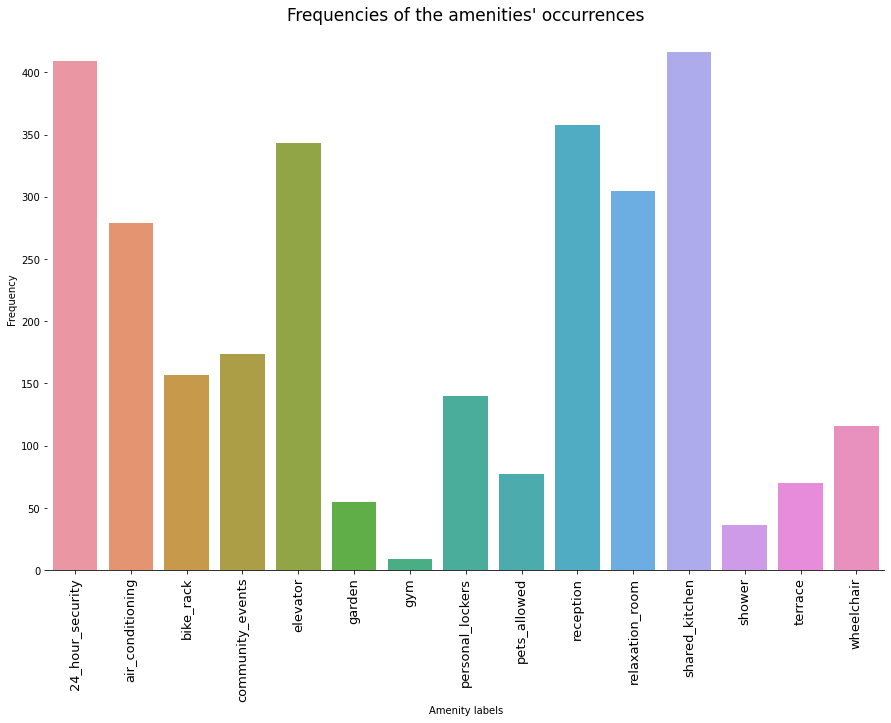

In [293]:
plot_df = pd.DataFrame(df[label_names].sum(), columns = ['count']).reset_index().rename(columns = {'index':'labels'})
plt.figure(figsize = (15, 10))
sns.barplot(plot_df['labels'], plot_df['count'])
plt.xticks(rotation = 90, size = 13)
plt.title("Frequencies of the amenities' occurrences", size = 17)
plt.ylabel('Frequency')
plt.xlabel('Amenity labels')
plt.savefig('/plots/Frequency_Distribution_Labels.png')
plt.show()

Splitting the offices.

In [10]:
def train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed):

  np.random.seed(seed)

  train_offices = np.random.choice(df['location_id'], num_train_offices, replace = False)
  valid_offices = np.random.choice(df[~df['location_id'].isin(train_offices)]['location_id'], num_valid_offices, replace = False)
  test_offices = np.random.choice(df[~df['location_id'].isin(np.concatenate((train_offices, valid_offices)))]['location_id'], num_test_offices, replace = False)

  return (train_offices, valid_offices, test_offices)

In [11]:
train_offices, valid_offices, test_offices = train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed)

print(f'number of offices in training set: {len(train_offices)}')
print(f'number of offices in validation set: {len(valid_offices)}')
print(f'number of offices in test set: {len(test_offices)}')

number of offices in training set: 300
number of offices in validation set: 79
number of offices in test set: 78


Loading and storing the offices' pictures as 3D arrays and the numbers of pictures per office.

In [12]:
#@title Default title text
def load_images(offices):

    #initializing the lists for storing both pictures and number of pictures for each office.
    imgs = []
    num_pics = []

    #for each office, load and store all the pictures and the number of pictures into respective lists.
    for off in offices:

        folder_path = f'photos/office_{off}/'

        i = 0

        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))

            if img is not None:

                imgs.append(img)
                i += 1

        num_pics.append(i)

    return imgs, num_pics

In [13]:
train_imgs, train_num_pics = load_images(train_offices)
print(f'number of pictures in training set: {sum(train_num_pics)}')

number of pictures in training set: 1657


In [14]:
valid_imgs, valid_num_pics = load_images(valid_offices)
print(f'number of pictures in validation set: {sum(valid_num_pics)}')

number of pictures in validation set: 431


In [15]:
test_imgs, test_num_pics = load_images(test_offices)
print(f'number of pictures in test set: {sum(test_num_pics)}')

number of pictures in test set: 415


In [16]:
train_valid_imgs, train_valid_num_pics = train_imgs + valid_imgs, train_num_pics + valid_num_pics
print(f'number of pictures in joind training and validation set: {sum(train_valid_num_pics)}')

number of pictures in joind training and validation set: 2088


Processing of images including resizing, normalization and conversion of numpy arrays into tensors.

In [17]:
def prep_images(imgs, resize_dim = 100, normalization = True, tf_conversion = True):

    prep_images = []

    for img in imgs:
        res_norm_img = cv2.resize(img, (resize_dim, resize_dim)) #resizing the pictures.
        prep_images.append(res_norm_img)
    
    if normalization:
        prep_images = [img/255.0 for img in prep_images] #normalizing the pictures.

    if tf_conversion:
        prep_images = tf.stack(prep_images) #conversion of numpy arrays into tensors.

    return prep_images

In [18]:
train_tf_imgs = prep_images(train_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [19]:
valid_tf_imgs = prep_images(valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [20]:
test_tf_imgs = prep_images(test_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [21]:
train_valid_tf_imgs = prep_images(train_valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [22]:
print(f'training shape: {train_tf_imgs.shape}')
print(f'validation shape: {valid_tf_imgs.shape}')
print(f'test shape: {test_tf_imgs.shape}')
print(f'joined training and validation shape: {train_valid_tf_imgs.shape}')

training shape: (1657, 100, 100, 3)
validation shape: (431, 100, 100, 3)
test shape: (415, 100, 100, 3)
joined training and validation shape: (2088, 100, 100, 3)


Processing of the classes/labels.

In [23]:
def prep_labels(df, offices, num_pics):

    #initializing a data frame for storing the labels for each office.
    labels_df = pd.DataFrame(columns = list(df.columns)[1:])

    #since we don't have the labels for each picture but rather for each office instead, we gonna replicate the labels for all pictures per office.

    #for each ffice, replicate the labels for all pictures of given office.
    for num, pic in zip(num_pics, offices): #for each office (with corresponding number of pictures)
        for _ in range(num): #for each picture of given office.
            labels_row = df.query(f'location_id == {pic}').drop('location_id', axis = 1) #filter the labels of given office
            labels_df = pd.concat((labels_df, labels_row)) #store the labels into a data frame.

    #conversion of the labels from data frame into numpy arrays with subsequent conversion into tensors.
    tf_labels = tf.constant([labels_df.to_numpy()])[0]

    return tf_labels

In [24]:
train_valid_offices = np.concatenate((train_offices, valid_offices))

In [25]:
train_tf_labels = prep_labels(df, train_offices, train_num_pics)
valid_tf_labels = prep_labels(df, valid_offices, valid_num_pics)
test_tf_labels = prep_labels(df, test_offices, test_num_pics)
train_valid_tf_labels = prep_labels(df, train_valid_offices, train_valid_num_pics)

## **CNN Modelling & Bayesian Optimization**

Function for model building as an input for Bayesian Optimization.

We tune:
- the number of convolutional blocks,
- the value of the filters (number of output filters in the convolution),
- the type of the pooling (whether use Max Pooling or Average Pooling),
- the number of units in the dense layer,
- the value of the dropout rate in the dropout layer in order to prevent overfitting,
- the value of the learning rate of stochastic gradient descent method in the Adam optimizer.

In [26]:
def model_building(hp):

  global dim_size

  inputs = Input(shape = (dim_size, dim_size, 3))
  x = inputs

  for i in range(hp.Int('conv_blocks', min_value = 3, max_value = 5, default = 3)):
    filters = hp.Int('filters_' + str(i), min_value = 32, max_value = 256, step = 32) 
    
    for _ in range(2):

      x = Conv2D(filters, kernel_size=(3, 3), padding = 'same', activation = 'relu')(x)
      x = BatchNormalization()(x)


    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
        x = MaxPooling2D()(x)
    else:
        x = AveragePooling2D()(x)
    
    x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  x = Flatten()(x)
  x = Dense(hp.Int('Dense units' ,min_value = 30, max_value = 100, step = 10, default = 50),
                  activation='relu')(x)

  x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  global label_names

  outputs = Dense(len(label_names), activation = 'sigmoid')(x)
  
  model = Model(inputs, outputs, name = 'CNN_PN')

  model.compile(optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate',
                                                              min_value = 1e-4,
                                                              max_value =1e-2,
                                                              sampling='log')), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

Initialization of Bayesian Optimization object while minimizing validation loss

In [27]:
bayes_opt = kt.tuners.BayesianOptimization(model_building, objective = 'val_loss', max_trials = 100, seed = seed)

Hyperparameter tuning using Bayesian Optimization for search the best hyperparameter values

In [28]:
bayes_opt.search(train_tf_imgs, train_tf_labels,
                 validation_data = (valid_tf_imgs, valid_tf_labels), 
                 epochs = 100,
                 callbacks = [EarlyStopping(patience = 69)])

Accessing the best hyperparameters' values

In [29]:
best_hypers = bayes_opt.get_best_hyperparameters(num_trials=1)[0]

In [30]:
display(best_hypers.values)

{'conv_blocks': 5,
 'filters_0': 256,
 'pooling_0': 'max',
 'dropout': 0.5,
 'filters_1': 32,
 'pooling_1': 'max',
 'filters_2': 256,
 'pooling_2': 'avg',
 'Dense units': 30,
 'learning_rate': 0.01,
 'filters_3': 256,
 'pooling_3': 'avg',
 'filters_4': 32,
 'pooling_4': 'avg'}

Final tuned model building

In [31]:
final_model = bayes_opt.hypermodel.build(best_hypers)

Model visualization

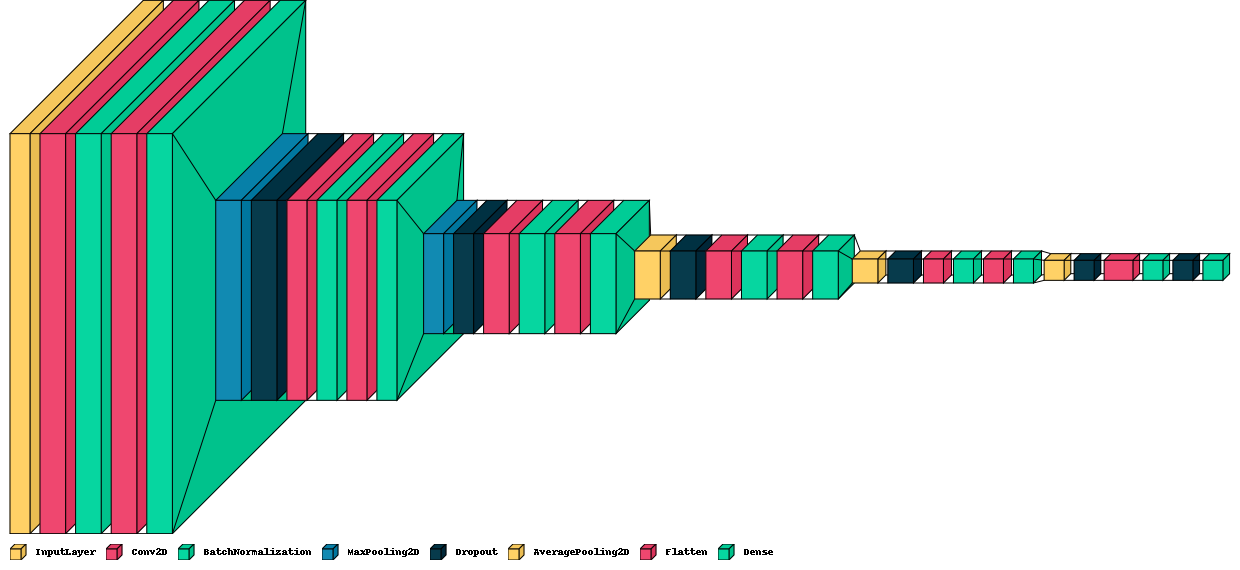

In [32]:
#Visual Keras
visualkeras.layered_view(final_model, legend=True)

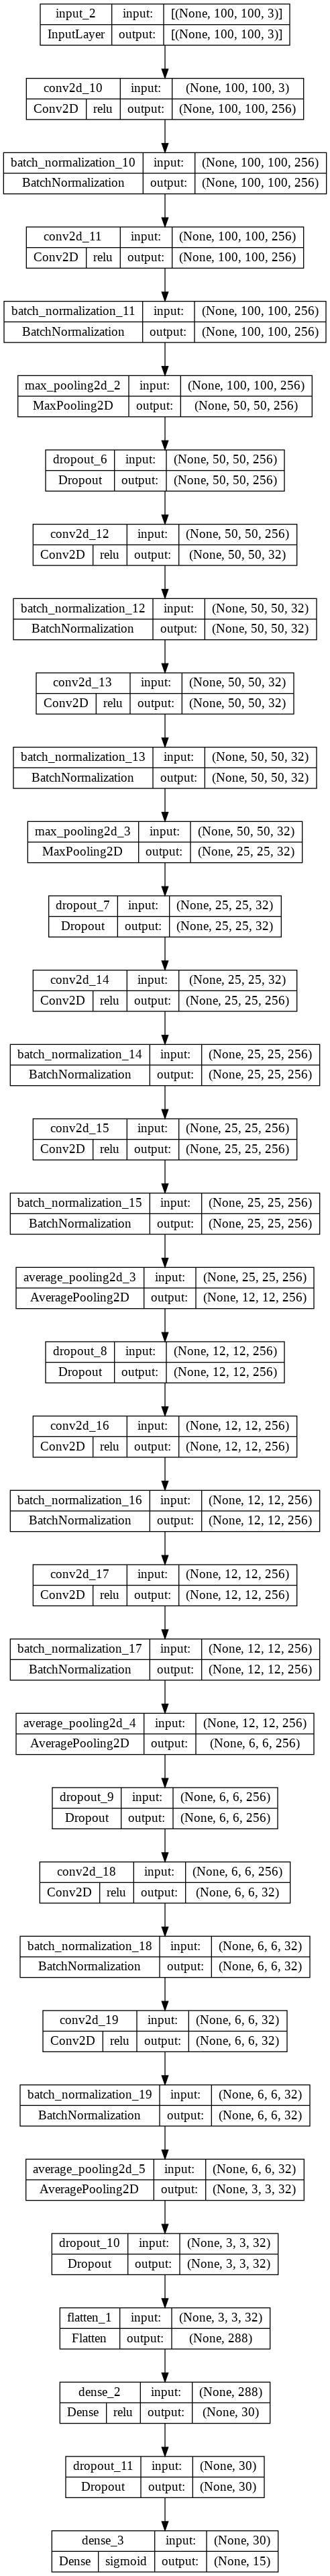

In [294]:
#Keras Model Plot
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_activations=True,
                          show_layer_names = True, expand_nested = True,
                          to_file='plots/CNN_PN__Keras_Plot_Model.png')

Model summary

In [34]:
final_model.summary()

Model: "CNN_PN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 256)     7168      
                                                                 
 batch_normalization_10 (Bat  (None, 100, 100, 256)    1024      
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 256)     590080    
                                                                 
 batch_normalization_11 (Bat  (None, 100, 100, 256)    1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 256)      0    

Final model training on the joined training and validation set
- since we already used an information from validation set when searching for the best hyperparameters' values, we will increase the size of the sample for the model training in order to increase the model performance and better generalization.

In [35]:
history = final_model.fit(train_valid_tf_imgs, train_valid_tf_labels,
                          epochs = 100, verbose = 1,
                          callbacks = [EarlyStopping(patience = 80)])

Epoch 1/100
66/66 [==============================] - 4s 40ms/step - loss: 0.5629 - accuracy: 0.3491
Epoch 2/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4841 - accuracy: 0.3180
Epoch 3/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4724 - accuracy: 0.2337
Epoch 4/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4660 - accuracy: 0.2280
Epoch 5/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4605 - accuracy: 0.2625
Epoch 6/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4561 - accuracy: 0.2989
Epoch 7/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4539 - accuracy: 0.3070
Epoch 8/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4525 - accuracy: 0.2720
Epoch 9/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4527 - accuracy: 0.2059
Epoch 10/100
66/66 [==============================] - 2s 35ms/step - loss: 0.4498 - accuracy: 0.2577

Saving the final model

In [51]:
final_model.save('CNN_PN.h5')
final_model.save('CNN_PN')

# **Evaluation**

Dictionary of offices and their images' indices.

In [52]:
def office_indexing(offices, num_pics):
    offices_dict = {}

    k = 0 #initializing an index
    ind_list = [] # initializing a list for storing starting and ending indices per each office.

    for office, no_pic in zip(offices, num_pics):
        #k is an starting index for given office
            #an ending index is the starting index incremented by the number of pictures of given office.
            #since the Python indexing starts from 0, we need to decrease the the ending index by 1.
        ind_list = [k, k+no_pic-1] 
        offices_dict[office] = ind_list
        
        #adjusting the starting index for next office by incremeting the index by number of pictures of the previous office.
        k += no_pic

    return offices_dict

In [53]:
train_offices_dict = office_indexing(train_offices, train_num_pics)
valid_offices_dict = office_indexing(valid_offices, valid_num_pics)
test_offices_dict = office_indexing(test_offices, test_num_pics)

Choosing a single office(s) for further single evaluation(s).

In [54]:
single_train_office = np.random.choice(train_offices, 1)[0]
single_valid_office = np.random.choice(valid_offices, 1)[0]
single_test_office = np.random.choice(test_offices, 1)[0]

Plotting the pictures of given office.

In [55]:
def plot_office(office):
    path_pic =  f'photos/office_{office}/'

    for pic in os.listdir(path_pic):
        img = cv2.imread(os.path.join(path_pic, pic))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Office {office} ({os.path.join(path_pic, pic).split("/")[-1]})', size = 15)
        plt.show()

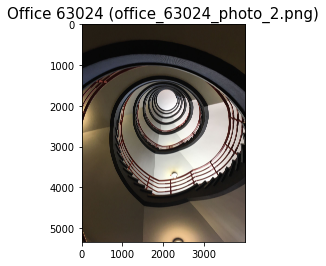

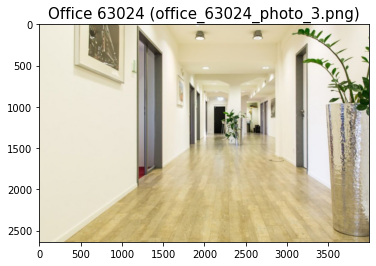

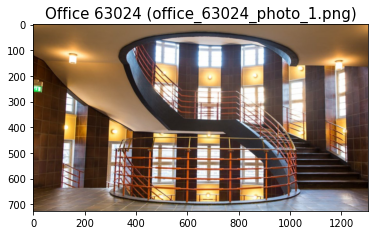

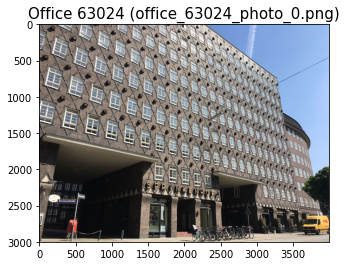

In [56]:
plot_office(single_test_office)

Class predictions based on the trained model, for given office.

In [57]:
def office_predictions(model, tf_imgs, offices_dict, office):
    
    start_ind = min(offices_dict[office])
    end_ind = max(offices_dict[office]) + 1

    office_probs= model.predict(tf_imgs[start_ind:end_ind])

    return office_probs

In [58]:
single_train_office_preds = office_predictions(final_model, train_tf_imgs, train_offices_dict, single_train_office)
single_valid_office_preds = office_predictions(final_model, valid_tf_imgs, valid_offices_dict, single_valid_office)
single_test_office_preds = office_predictions(final_model, test_tf_imgs, test_offices_dict, single_test_office)

1/1 [==============================] - 0s 235ms/step


Evaluation of the single office's predictions based on predicted probabilites.
- Based on predicted probabilities of each photo of given office, we average them to get the aggregated probabilities of given office.
- based on the aggregated probabilities for each amenity label, we then use a default threshold 0.5 for a classification in order to get a predicted class for each amenity label (1 what is being above threshold, else 0).
- Then, we compare the predicted classes with the true classes in order to get the outcome, whether the the class for each amenity has been correctly classified.
  - whether the true occurences of amenity labels have been indeed correctly classified as true occurences, or
  - whether the true non-occurences of amenity labels have been indeed correctly classified as true-non occurences).

In [59]:
def office_evaluation(predictions, label_names, df, office):

    #storing predicted probabilites and the the label names into a data frame.
    eval_df = pd.DataFrame(pd.DataFrame(predictions, columns = label_names).mean(),
                           columns = ['prob']).reset_index().rename(columns = {'index':'var'})

    #classification of classes (occurences) based on probabilities with a default threshold 0.5.
    eval_df['pred'] = eval_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #joining the predicted classes (occurences) with the true classes (occurences).
    eval_df = pd.concat((eval_df,
                        pd.DataFrame(df[df['location_id'] == office].drop('location_id', axis = 1).values).transpose()),
                        axis=1).rename(columns = {'index':'var', 0:'true'})

    #indicator whether the predicted class (occurence) is the same as the true class (occurence).
    eval_df['outcome'] = [1 if i == j else 0 for i, j in zip(eval_df['pred'], eval_df['true'])]

    return eval_df

In [60]:
single_train_eval_df = office_evaluation(single_train_office_preds, label_names, df, single_train_office)
single_valid_eval_df = office_evaluation(single_valid_office_preds, label_names, df, single_train_office)
single_test_eval_df = office_evaluation(single_test_office_preds, label_names, df, single_train_office)

In [61]:
display(single_train_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.936197,1,1,1
1,air_conditioning,0.750550,1,1,1
2,bike_rack,0.047323,0,0,1
3,community_events,0.081587,0,0,1
4,elevator,0.836832,1,1,1
5,garden,0.004939,0,0,1
6,gym,0.000419,0,0,1
7,personal_lockers,0.098572,0,0,1
8,pets_allowed,0.003406,0,0,1
9,reception,0.881966,1,1,1


In [62]:
display(single_valid_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.889809,1,1,1
1,air_conditioning,0.528832,1,1,1
2,bike_rack,0.360499,0,0,1
3,community_events,0.407937,0,0,1
4,elevator,0.723444,1,1,1
5,garden,0.128198,0,0,1
6,gym,0.027073,0,0,1
7,personal_lockers,0.370004,0,0,1
8,pets_allowed,0.190654,0,0,1
9,reception,0.773102,1,1,1


In [63]:
display(single_test_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.863321,1,1,1
1,air_conditioning,0.504213,1,1,1
2,bike_rack,0.327579,0,0,1
3,community_events,0.360384,0,0,1
4,elevator,0.698400,1,1,1
5,garden,0.121379,0,0,1
6,gym,0.026087,0,0,1
7,personal_lockers,0.342234,0,0,1
8,pets_allowed,0.176766,0,0,1
9,reception,0.752559,1,1,1


Plotting the probabilities per each amenity label of given office.
- if the probability is above the threshold 0.5 (red line), hence it's classified/predicted as 1 (predicted occurrence of given amenity label), else 0 (predicted non-occurrence of given amenity label).
- what is being colored as an orange bar, hence the true class is 1 (true occurrence given amenity label).
- what is being colored as a green bar, the true label is 0 (true of non-occurrence given amenity label).
- the desire outcome is either the orange bar being above the threshold and/or green bar being below the threshold.
  - In other words, the true occurrences shall be classified as occurrences and true non-occurrences shall be classified as non-occurrences.
- Morever, to each office, we calculate an office average accuracy a ratio of positive outcomes (outcome = 1) to the total number of all outcomes.
  - In other words, ratio of correctly classified amenities'occurrences and non-occurences.

In [249]:
def plot_office_evaluation(eval_df, office):
    plt.figure(figsize=(25,10))
    sns.barplot(data = eval_df, x = 'var',y='prob', hue = 'true', palette = 'Set2')
    plt.axhline(y = 0.5, color = 'r', linestyle = '-')
    plt.xticks(rotation = 90, size = 13)
    plt.yticks(size = 14)

    acc = f'Accuracy: {accuracy_score(eval_df.true, eval_df.pred)*100:.2f}%'
    f1 = f'F1: {f1_score(eval_df.true, eval_df.pred)*100:.2f}%'
    recall = f'Recall: {recall_score(eval_df.true, eval_df.pred)*100:.2f}%'
    precision = f'Precision: {precision_score(eval_df.true, eval_df.pred)*100:.2f}%'
    auc = f'AUC: {roc_auc_score(eval_df.true, eval_df.prob)*100:.2f}%'

    plt.text(-0.3,1.01,'\n'.join([acc, f1, recall, precision, auc]),
             fontsize = 14, bbox = dict(facecolor = 'pink', alpha = 0.7))
    plt.title(f'Office {office} - Probability distribution', size = 17)
    plt.ylim(0.0, 1.0+.05)
    plt.ylabel('Probability')
    plt.xlabel('Amenity labels')
    plt.show()

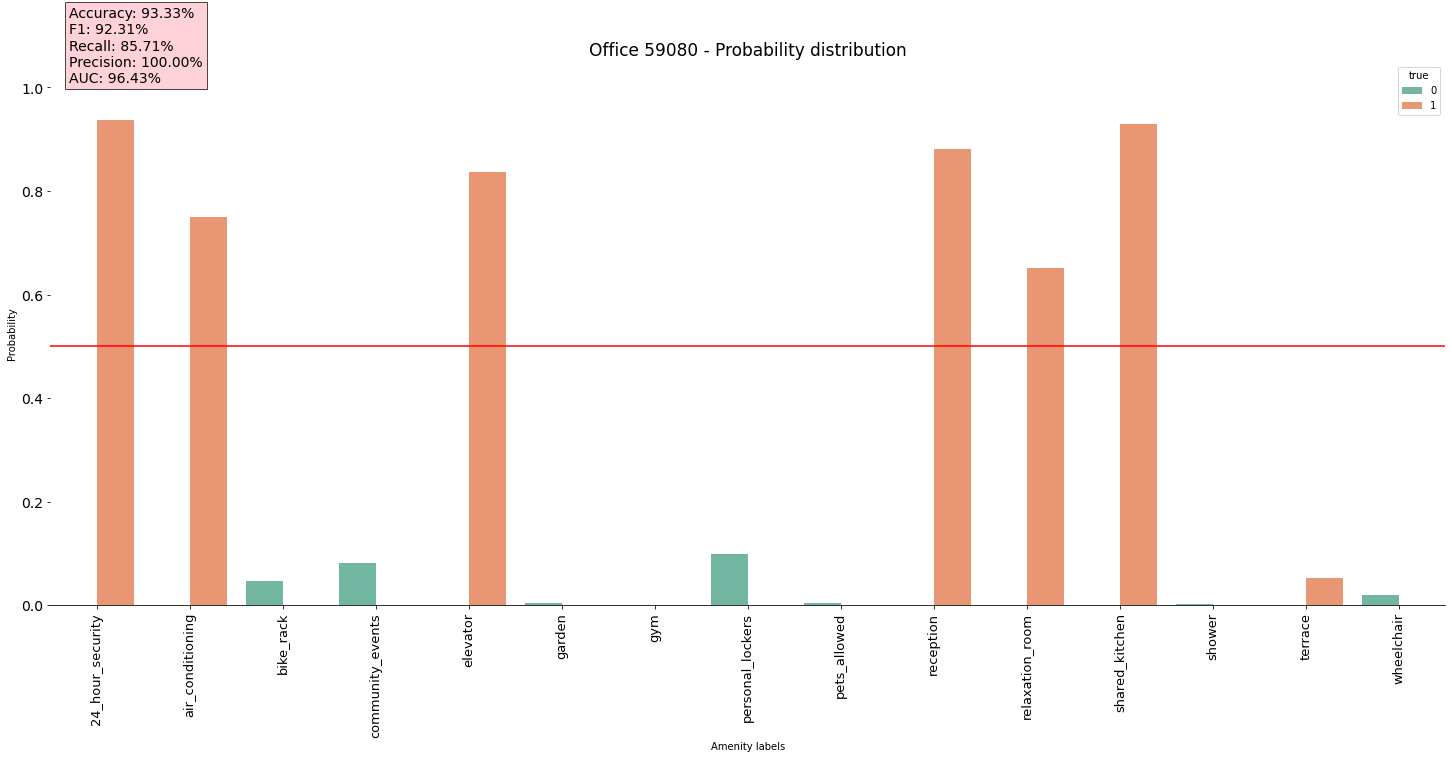

In [250]:
plot_office_evaluation(single_train_eval_df, single_train_office)

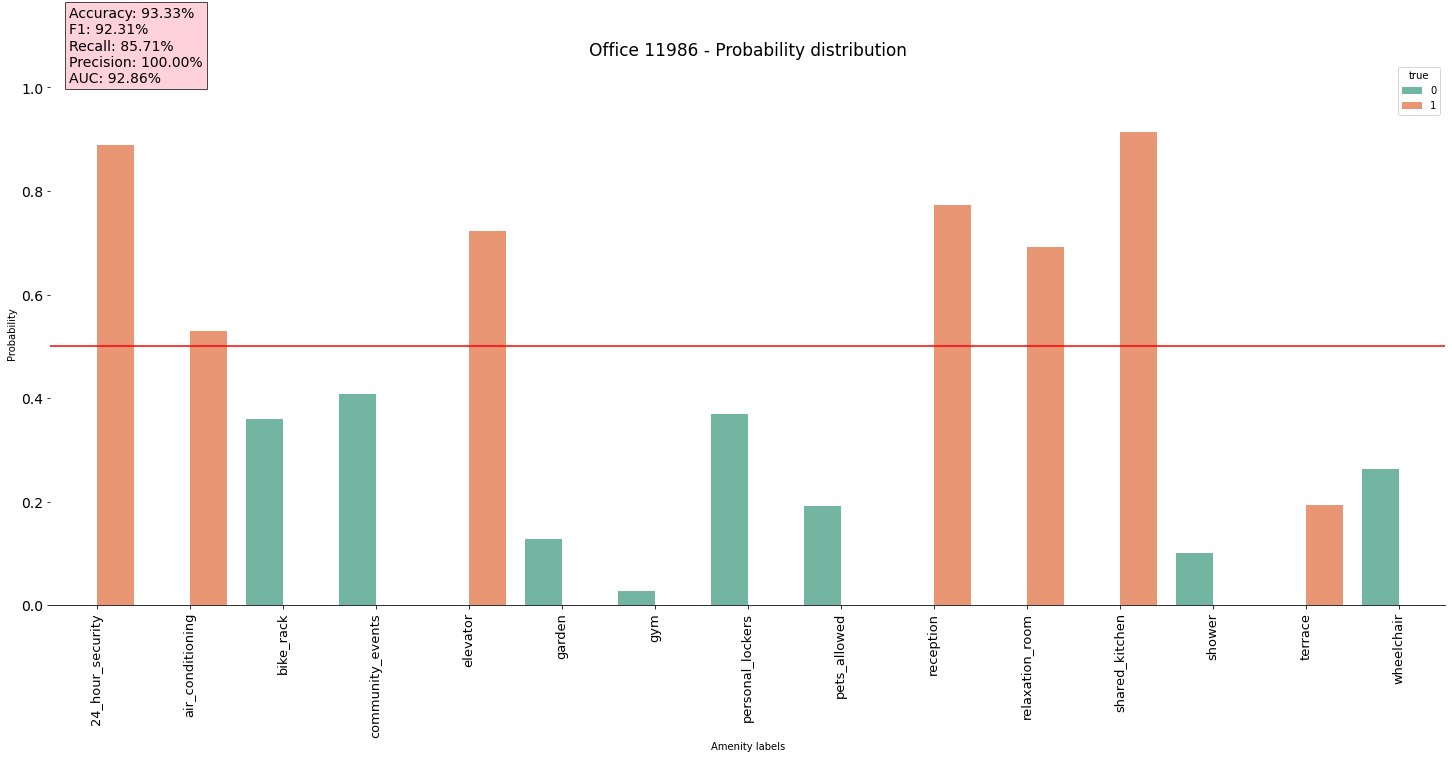

In [251]:
plot_office_evaluation(single_valid_eval_df, single_valid_office)

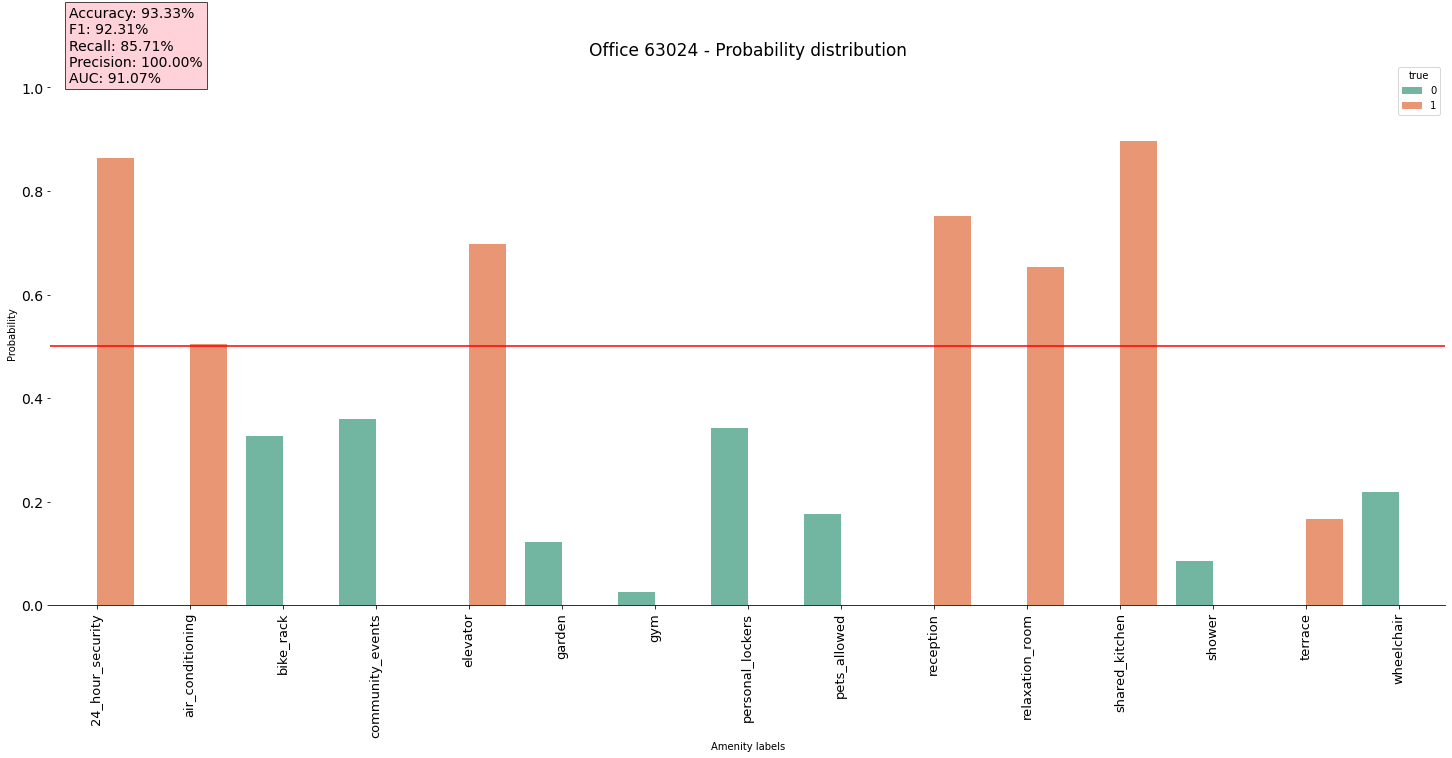

In [252]:
plot_office_evaluation(single_test_eval_df, single_test_office)

Predictions on the whole training/validation/test set.

In [84]:
train_all_predictions = final_model.predict(train_tf_imgs)

52/52 [==============================] - 1s 25ms/step


In [85]:
valid_all_predictions = final_model.predict(valid_tf_imgs)

14/14 [==============================] - 0s 9ms/step


In [86]:
test_all_predictions = final_model.predict(test_tf_imgs)

13/13 [==============================] - 1s 86ms/step


Evaluation of the model on the given set/sample.
- based on predicted probabilities for each offices' photo, we average them per office, in order to get agregated probabililites per each office.
- based on agregated probabilities per each office, we classify them with a default threshold 0.5 in order to get the predicted classes (amenities' occurrences).
- based on the predicted classes (amenities' occurrences) per office, we compare them with the true classes (amenities' occurences) per office.
- based on the comparison, we create an indicator whether the predicted classes (amenities' occurrences) are the same as the true classes (amenities' occurrences) per office (if they're the same 1, else 0).
- based on the indicators, we calculate the aggregated accuracies on the whole sample per each amenity label as the ratio of correctly classified occurences and non-occurences (per each amenity label).

In [138]:
def overall_evaluation(predictions, df, label_names, num_pics, offices):

    #data frame for storing true classes (occurences).
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))

    #data frame for storing predicted classes (occurences) based on probabilities.
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{i}_prob' for i in label_names]))


    #assigning the offices' names to each row.
    pred_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    #aggregating the probabilities by the offices.
    pred_df = pred_df.groupby('location_id')[[f'{i}_prob' for i in label_names]].mean().reset_index()

    for c in label_names:
      pred_df[c] = pred_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #joining the predicted classes (occurences) with the true classes (occurences).
    joined_df = pred_df.merge(df[df['location_id'].isin(offices)], on ='location_id', suffixes=('_pred','_true'))

    metrics_dict = {
                    'Accuracy': accuracy_score,
                    'F1': f1_score,
                    'Recall': recall_score,
                    'Precision': precision_score,
                    'AUC': roc_auc_score
                    }

    final_df = pd.DataFrame(index = label_names, columns = [f'Aggregated_{i}' for i in metrics_dict.keys()])
    for lab in label_names:
      for metric in metrics_dict.keys():
        if metric == 'AUC':
          final_df.loc[lab, f'Aggregated_{metric}'] = metrics_dict[metric](joined_df[f'{lab}_true'], joined_df[f'{lab}_prob'])
        else:
          final_df.loc[lab, f'Aggregated_{metric}'] = metrics_dict[metric](joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])

    return final_df.reset_index().rename(columns = {'index':'var'})

In [139]:
train_overall_ev_df = overall_evaluation(train_all_predictions, df, label_names, train_num_pics, train_offices)
valid_overall_ev_df = overall_evaluation(valid_all_predictions, df, label_names, valid_num_pics, valid_offices)
test_overall_ev_df = overall_evaluation(test_all_predictions, df, label_names, test_num_pics, test_offices)

In [140]:
display(train_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.893333,0.943662,1.0,0.893333,0.635669
1,air_conditioning,0.653333,0.753555,0.898305,0.64898,0.700106
2,bike_rack,0.68,0.058824,0.030303,1.0,0.796522
3,community_events,0.673333,0.209677,0.117117,1.0,0.818843
4,elevator,0.733333,0.846154,1.0,0.733333,0.734432
5,garden,0.876667,0.0,0.0,0.0,0.783064
6,gym,0.976667,0.0,0.0,0.0,0.793759
7,personal_lockers,0.716667,0.0,0.0,0.0,0.707141
8,pets_allowed,0.853333,0.0,0.0,0.0,0.782138
9,reception,0.78,0.876404,1.0,0.78,0.695254


In [141]:
display(valid_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.924051,0.960526,1.0,0.924051,0.783105
1,air_conditioning,0.696203,0.803279,0.942308,0.7,0.67094
2,bike_rack,0.632911,0.121212,0.066667,0.666667,0.843537
3,community_events,0.683544,0.285714,0.166667,1.0,0.85102
4,elevator,0.822785,0.902778,1.0,0.822785,0.584615
5,garden,0.898734,0.0,0.0,0.0,0.739437
6,gym,0.987342,0.0,0.0,0.0,0.705128
7,personal_lockers,0.670886,0.0,0.0,0.0,0.716981
8,pets_allowed,0.822785,0.0,0.0,0.0,0.778022
9,reception,0.822785,0.901408,1.0,0.820513,0.673958


In [142]:
display(test_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.871795,0.931507,1.0,0.871795,0.541176
1,air_conditioning,0.653846,0.765217,0.88,0.676923,0.574286
2,bike_rack,0.628205,0.0,0.0,0.0,0.592143
3,community_events,0.602564,0.114286,0.060606,1.0,0.639731
4,elevator,0.74359,0.852941,1.0,0.74359,0.612069
5,garden,0.871795,0.0,0.0,0.0,0.523529
6,gym,0.987179,0.0,0.0,0.0,0.142857
7,personal_lockers,0.628205,0.0,0.0,0.0,0.425757
8,pets_allowed,0.75641,0.0,0.0,0.0,0.67975
9,reception,0.769231,0.869565,1.0,0.769231,0.534259


In [143]:
train_overall_ev_df['set'] = 'train'
valid_overall_ev_df['set'] = 'valid'
test_overall_ev_df['set'] = 'test'
df_ev_overall = pd.concat((train_overall_ev_df, valid_overall_ev_df, test_overall_ev_df))
display(df_ev_overall)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC,set
0,24_hour_security,0.893333,0.943662,1.0,0.893333,0.635669,train
1,air_conditioning,0.653333,0.753555,0.898305,0.64898,0.700106,train
2,bike_rack,0.68,0.058824,0.030303,1.0,0.796522,train
3,community_events,0.673333,0.209677,0.117117,1.0,0.818843,train
4,elevator,0.733333,0.846154,1.0,0.733333,0.734432,train
5,garden,0.876667,0.0,0.0,0.0,0.783064,train
6,gym,0.976667,0.0,0.0,0.0,0.793759,train
7,personal_lockers,0.716667,0.0,0.0,0.0,0.707141,train
8,pets_allowed,0.853333,0.0,0.0,0.0,0.782138,train
9,reception,0.78,0.876404,1.0,0.78,0.695254,train


Plotting the aggregated accuracy per each amenity label and sample.
- Based on the aggregated accuracies, we calculate an overall average accuracy as the average of all the aggregated accuracies, which is visualized as a red horizontal line in a plot. 

In [144]:
metrics_list = ['Accuracy','F1','Recall','Precision','AUC']

In [258]:
def plot_overall_evaluation(df_overall_ev, metrics_list, total = True, sample_name = ''):
  for metric in metrics_list:
      plt.figure(figsize=(25,10))
      sns.barplot(data = df_overall_ev, x = 'var', y=f'Aggregated_{metric}', hue = 'set', palette = 'Set2')
      plt.yticks(size = 13)
      plt.ylabel(str.capitalize(metric))
      plt.xlabel('Amenity labels')
      plt.ylim(0.0, 1.0+.05)

      if total:
        plt.legend(prop={'size': 14})
        avg_metric = df_overall_ev[f'Aggregated_{metric}'].mean()
        plt.title(f'Aggregated {metric} per label and sample ... Overall {metric} = {avg_metric*100:.2f}%', size = 16)
        plt.xticks(rotation = 20, size = 15)
        plt.axhline(y = avg_metric, color = 'r', linestyle = '-')
        plt.savefig(f"plots/All_Aggregated_{metric}.png")

      else:
        plt.legend()
        avg_metric = df_overall_ev.query(f'set == "{sample_name}"')[f'Aggregated_{metric}'].mean()
        plt.title(f'Aggregated {metric} per label in {sample_name} sample ... Overall {metric} = {avg_metric*100:.2f}%', size = 18)
        plt.xticks(rotation = 90, size = 15)
        plt.axhline(y = avg_metric, color = 'r', linestyle = '-')
        plt.savefig(f"plots/{str.capitalize(sample_name)}_Aggregated_{metric}.png")

      plt.tight_layout()
      plt.show()

We can observe that the model does not overfit since the accuracies are in general very similar across the samples and as well, the model neither does not underfit since we can observe pretty high accuracies over all the samples in general.

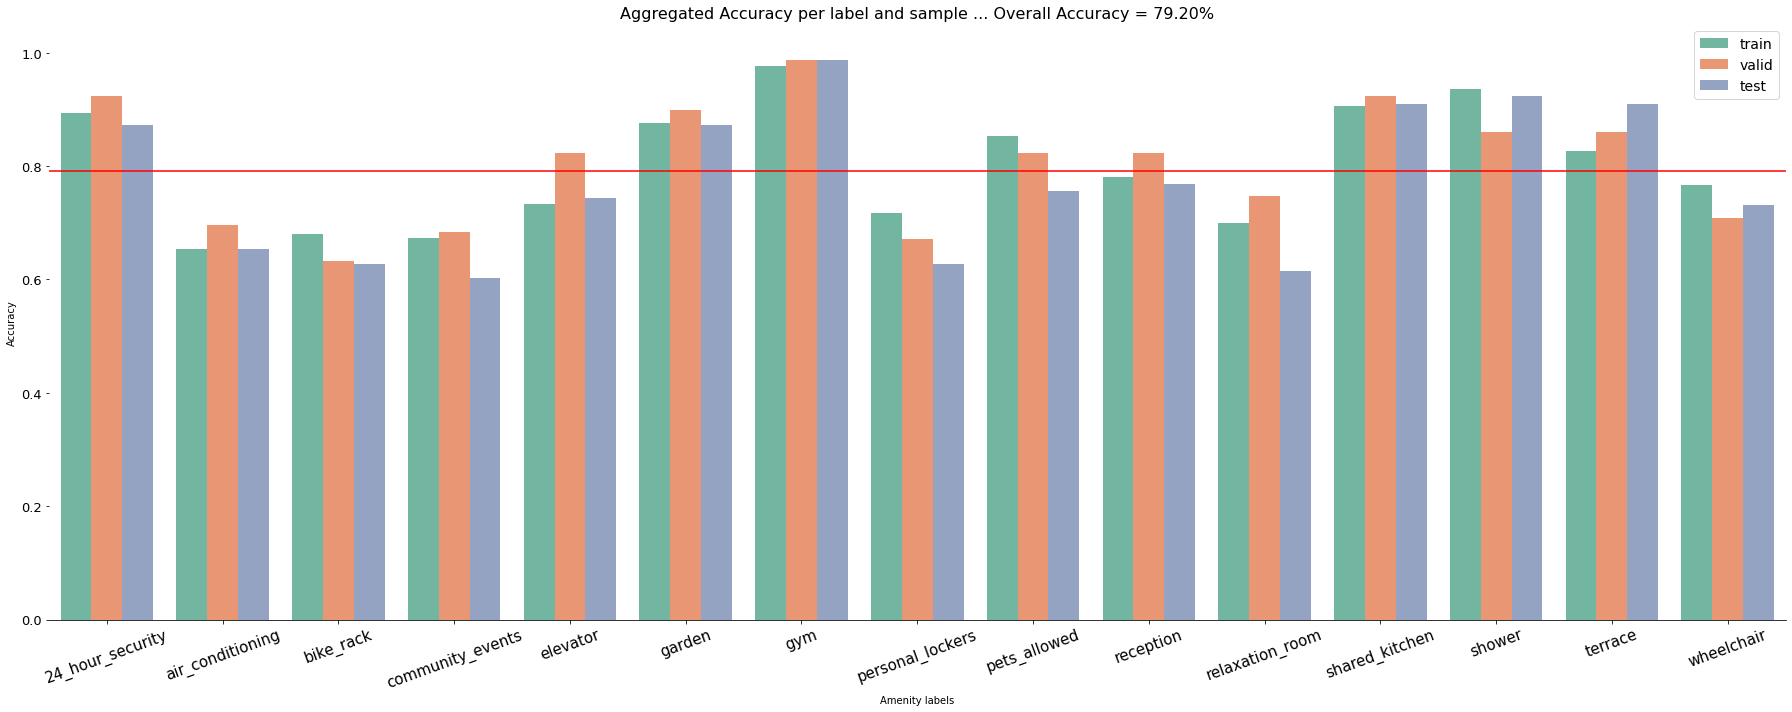

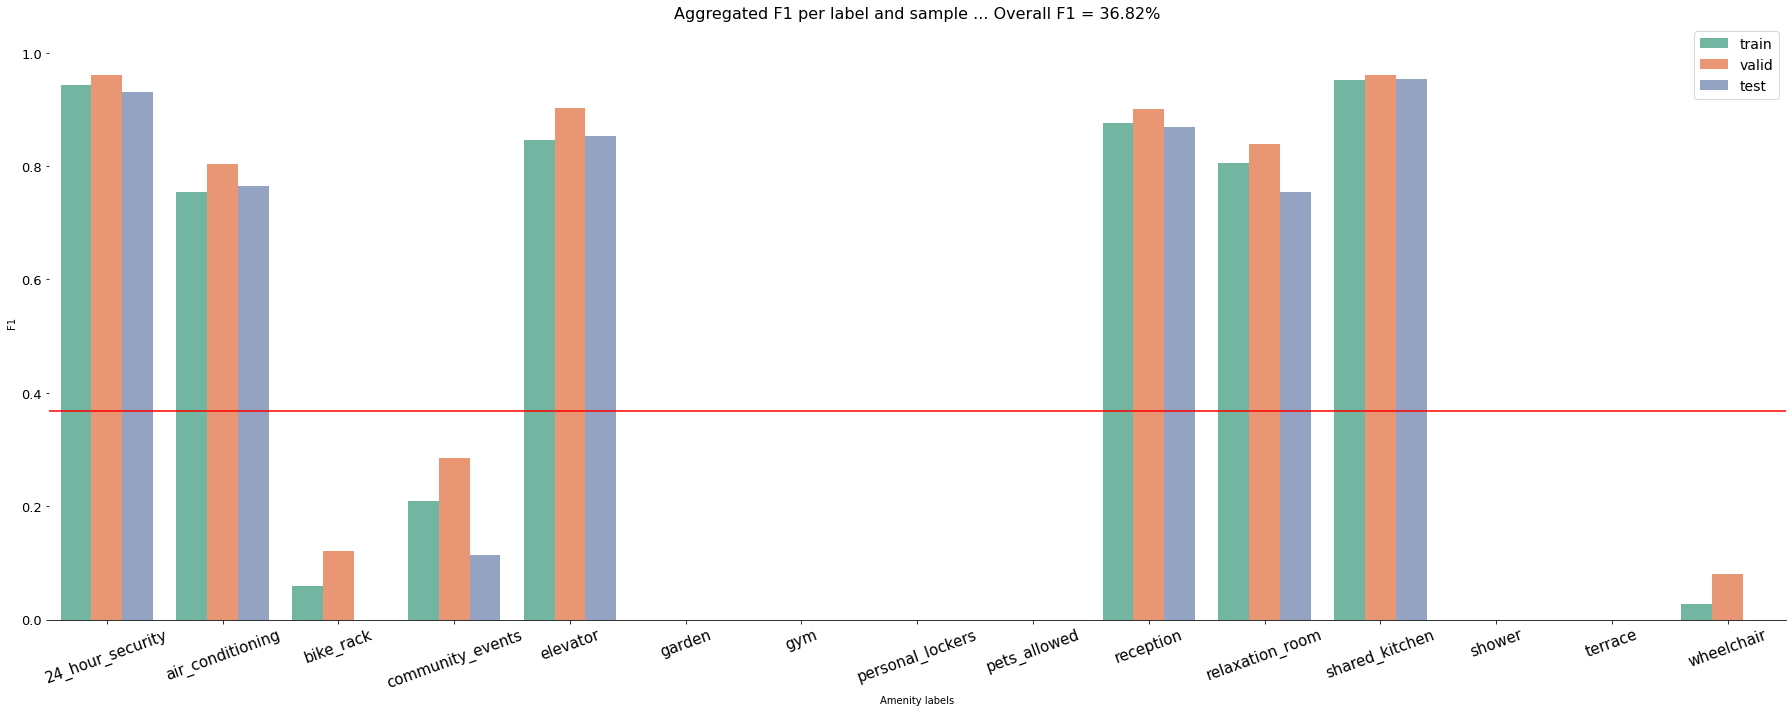

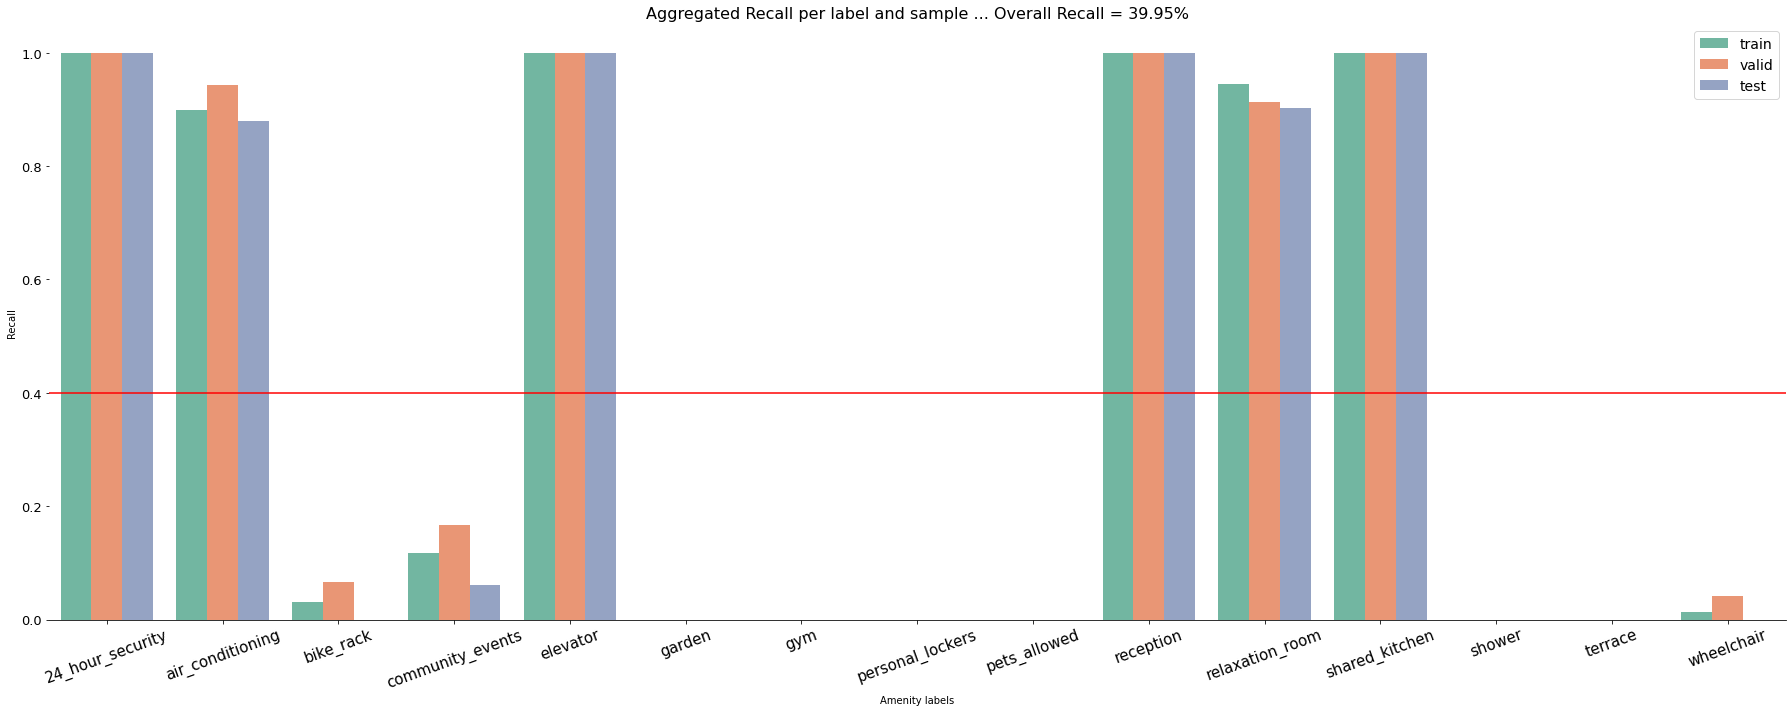

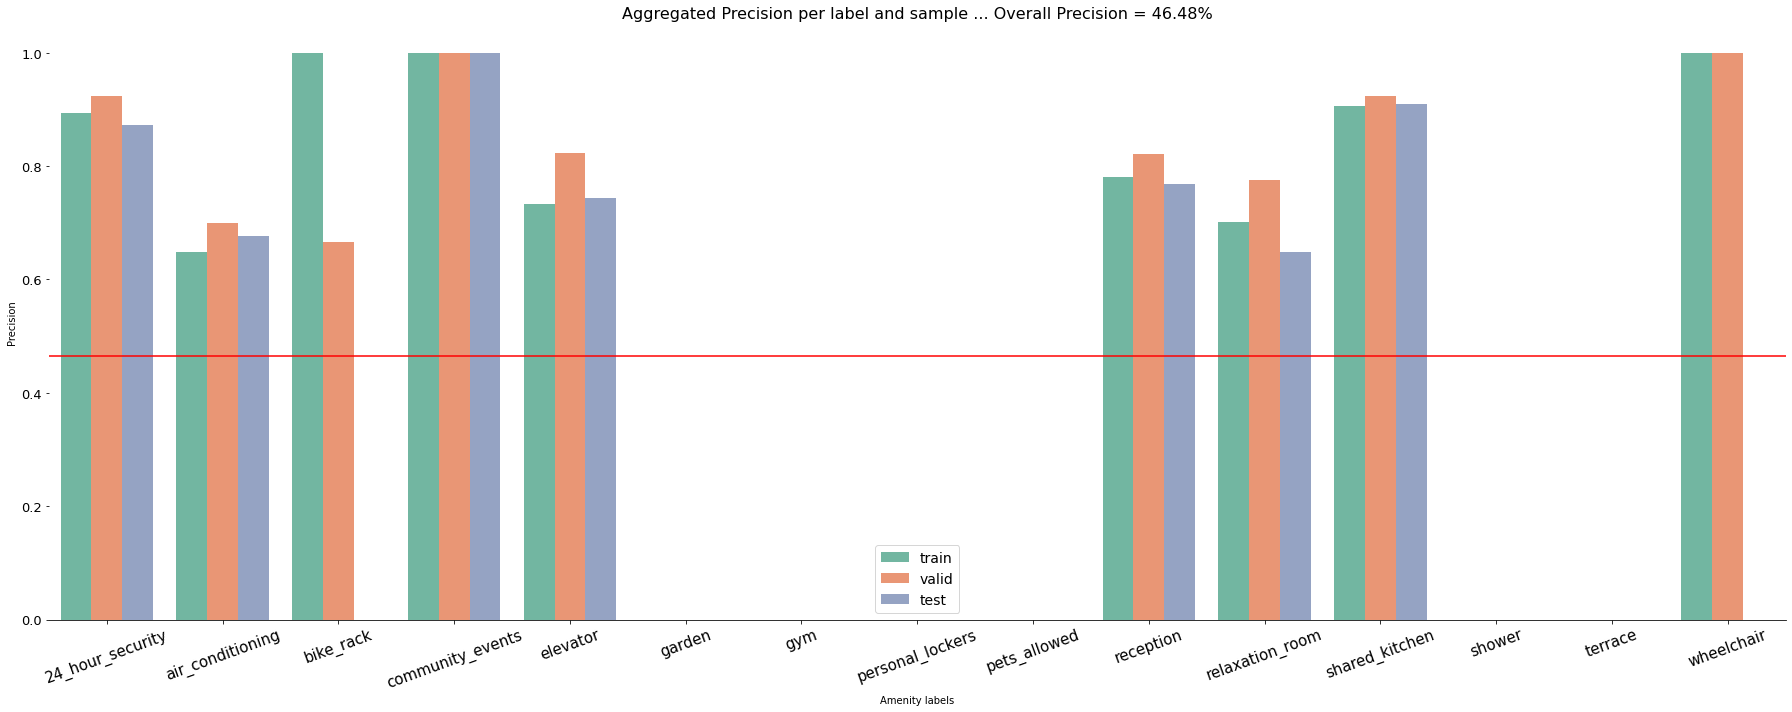

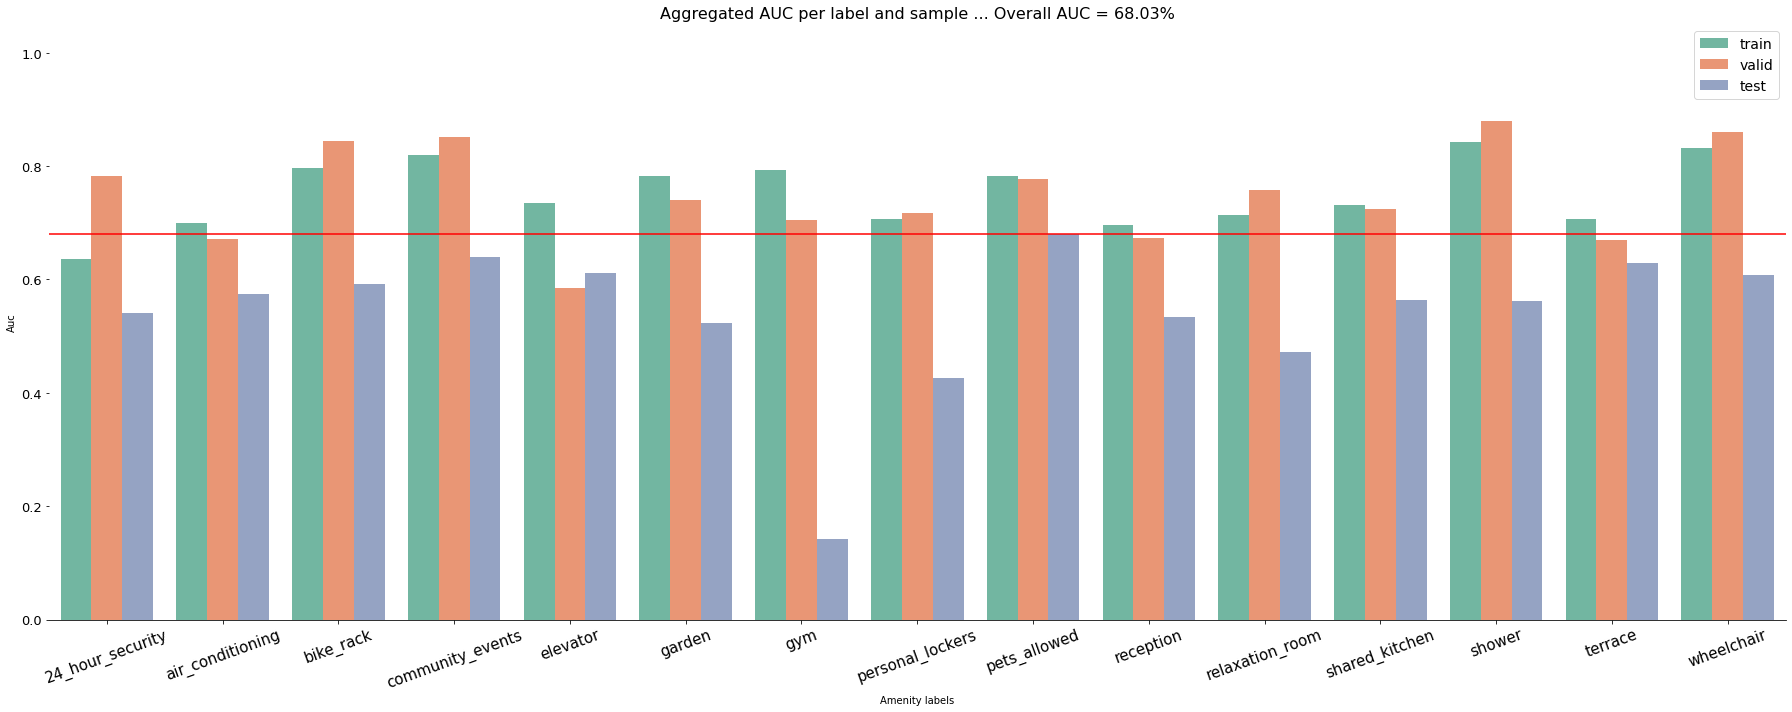

In [259]:
plot_overall_evaluation(df_ev_overall, metrics_list, total = True)

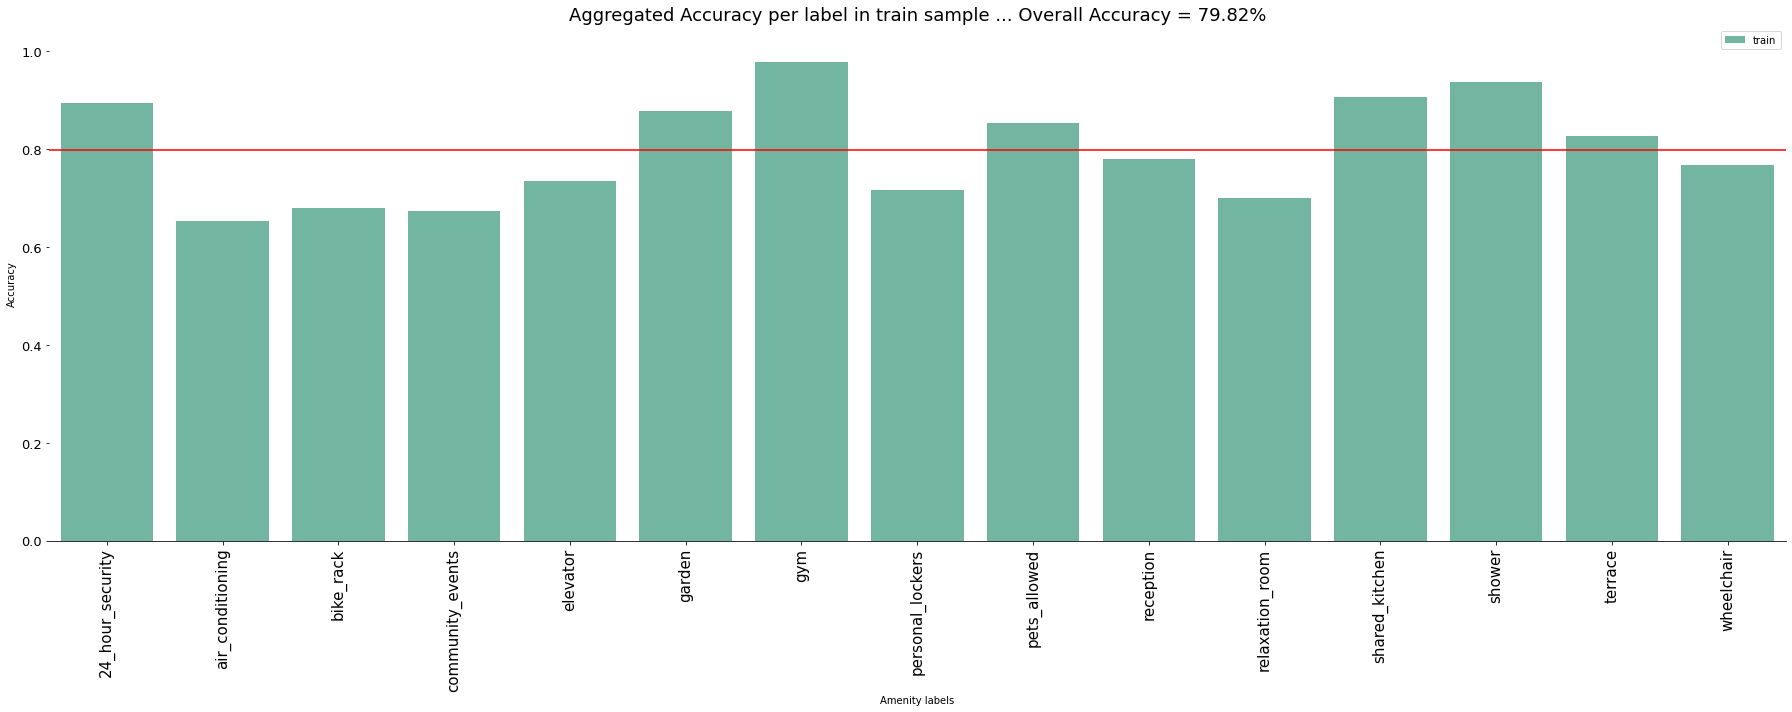

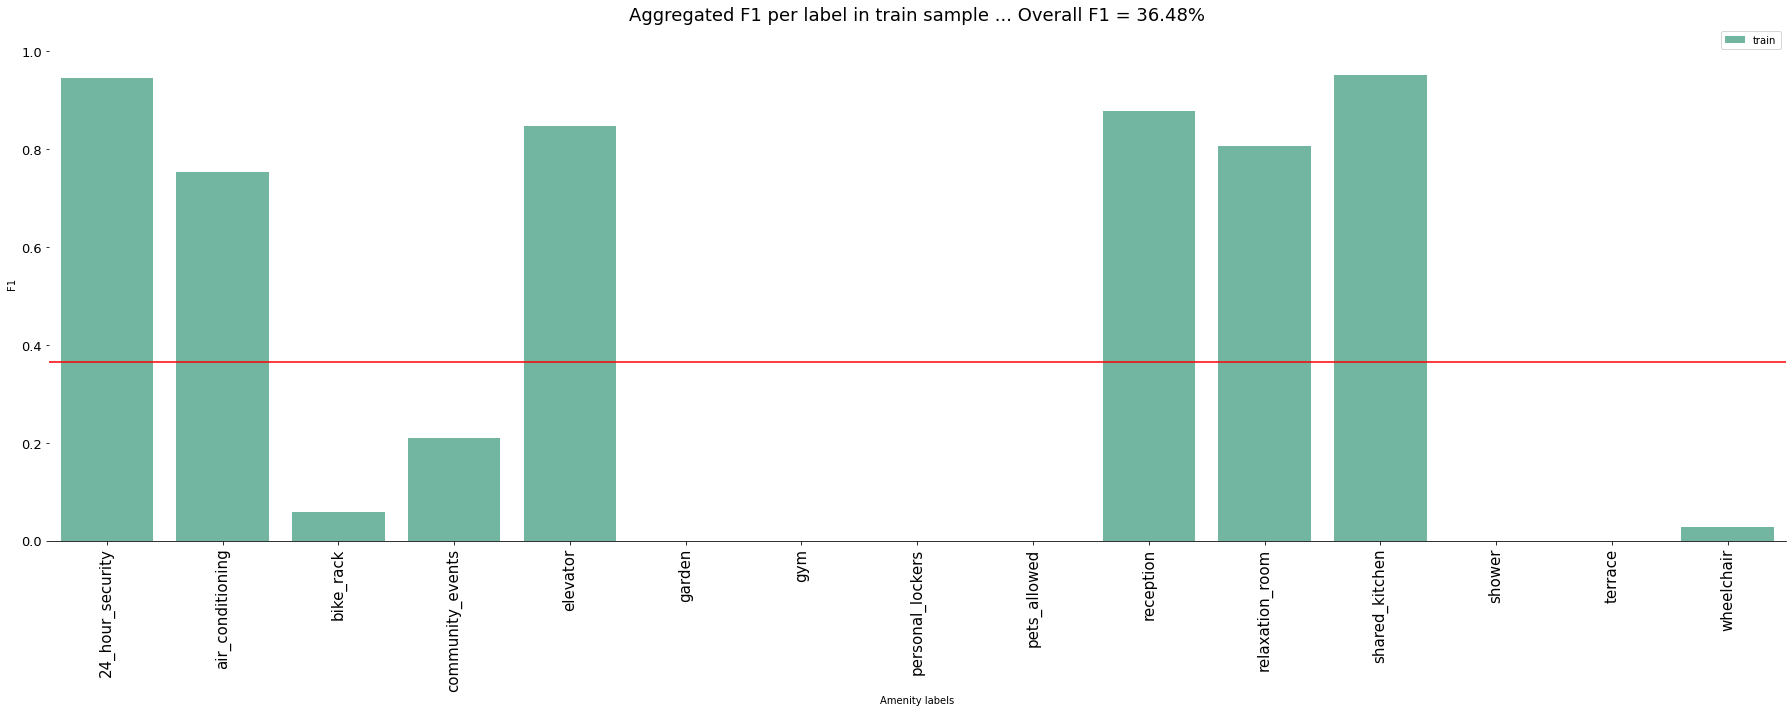

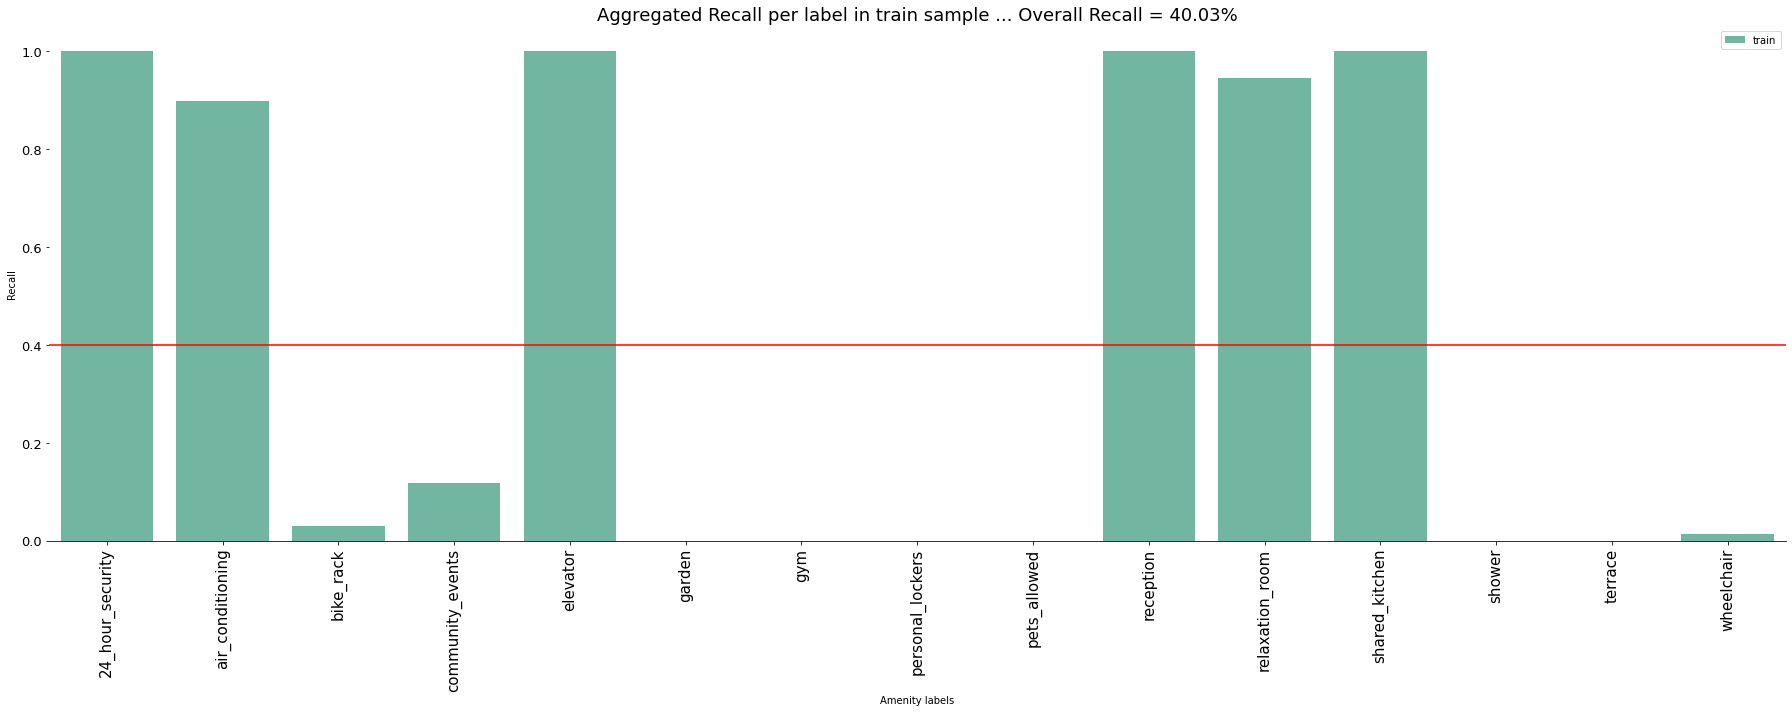

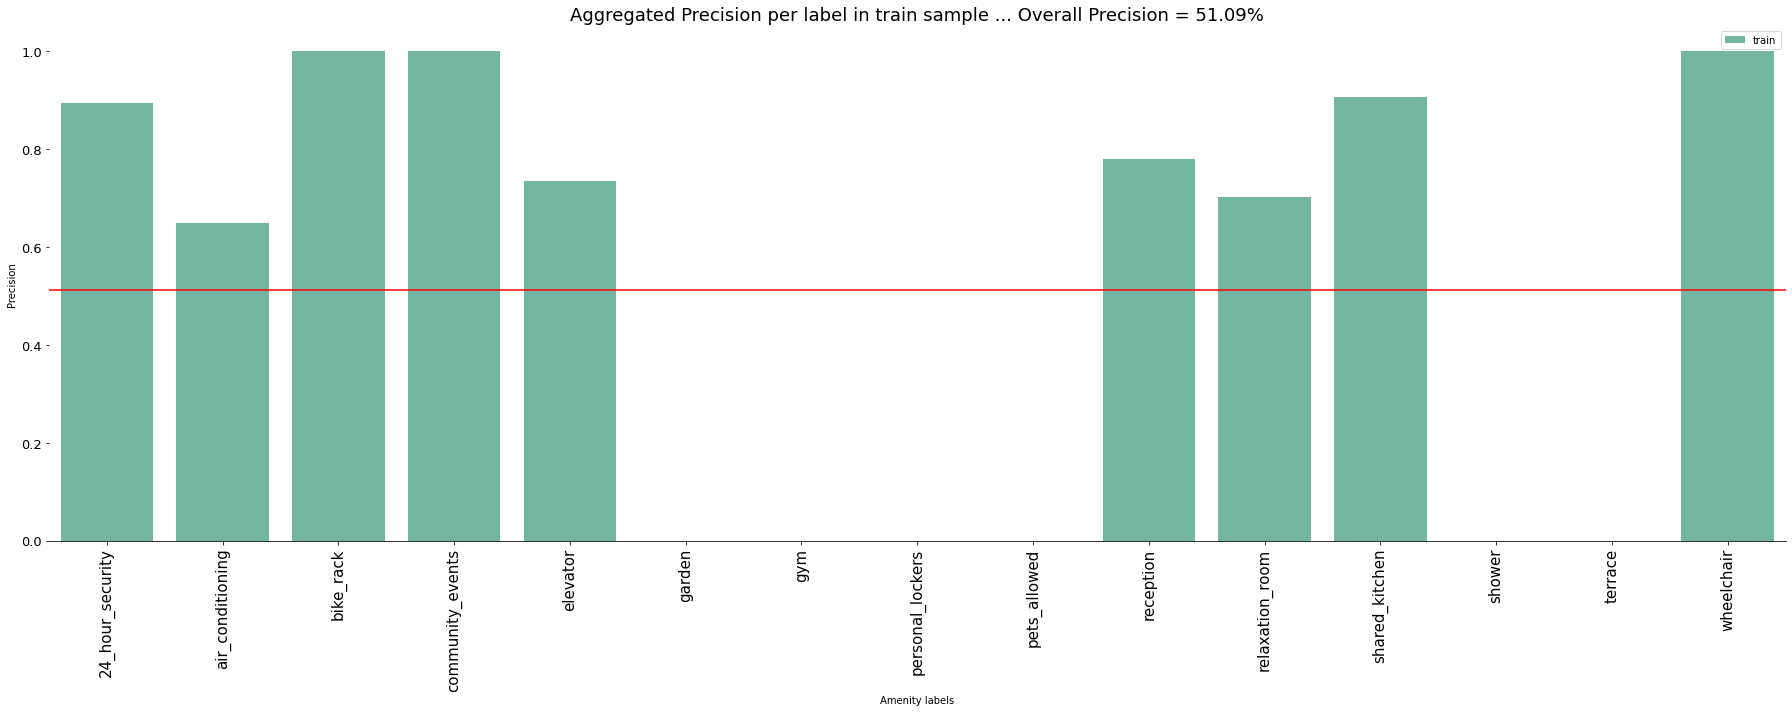

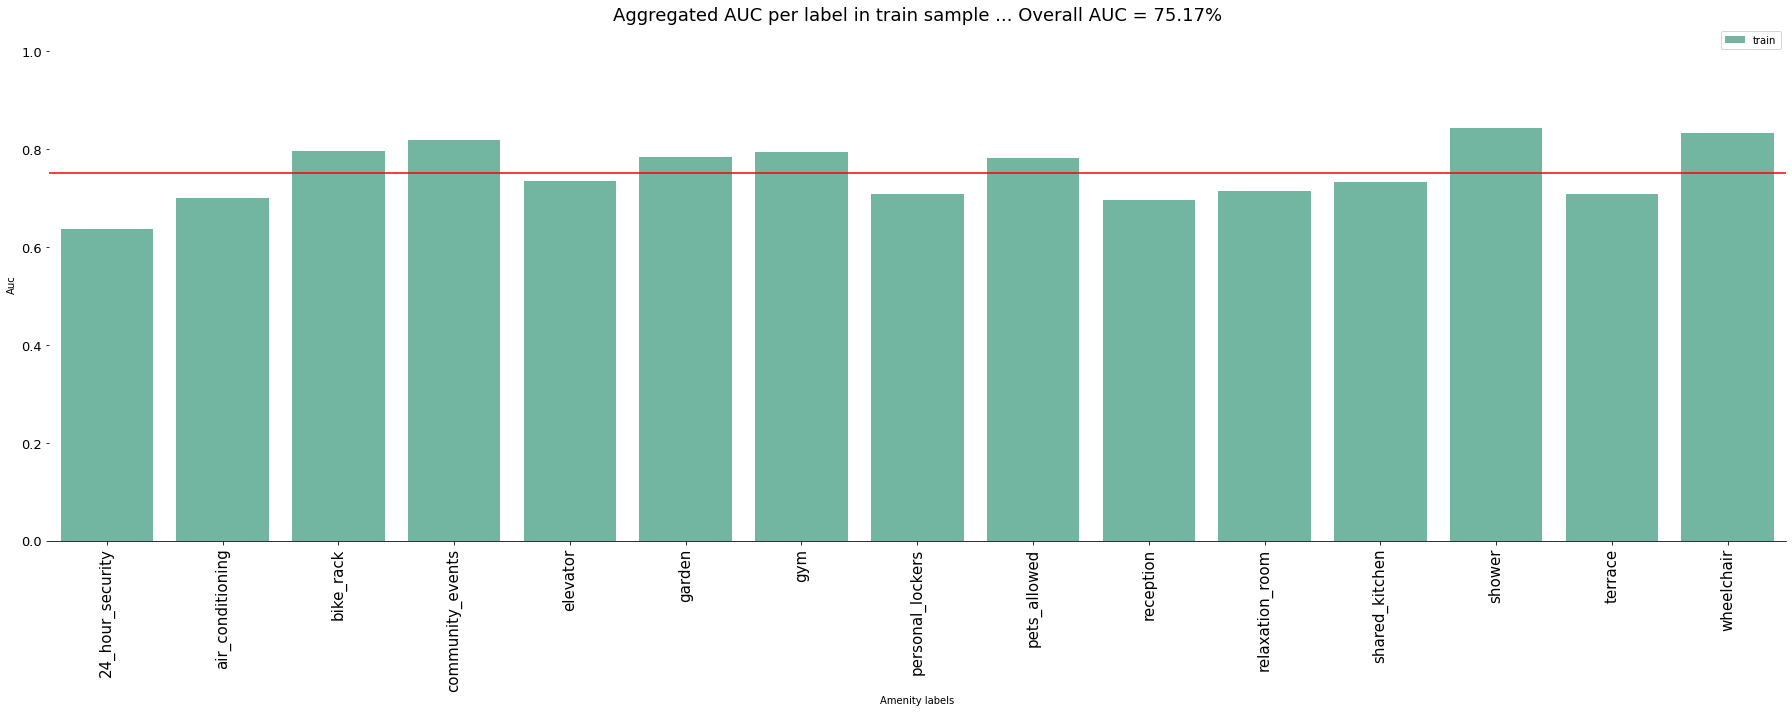

In [260]:
plot_overall_evaluation(train_overall_ev_df, metrics_list, total = False, sample_name = 'train')

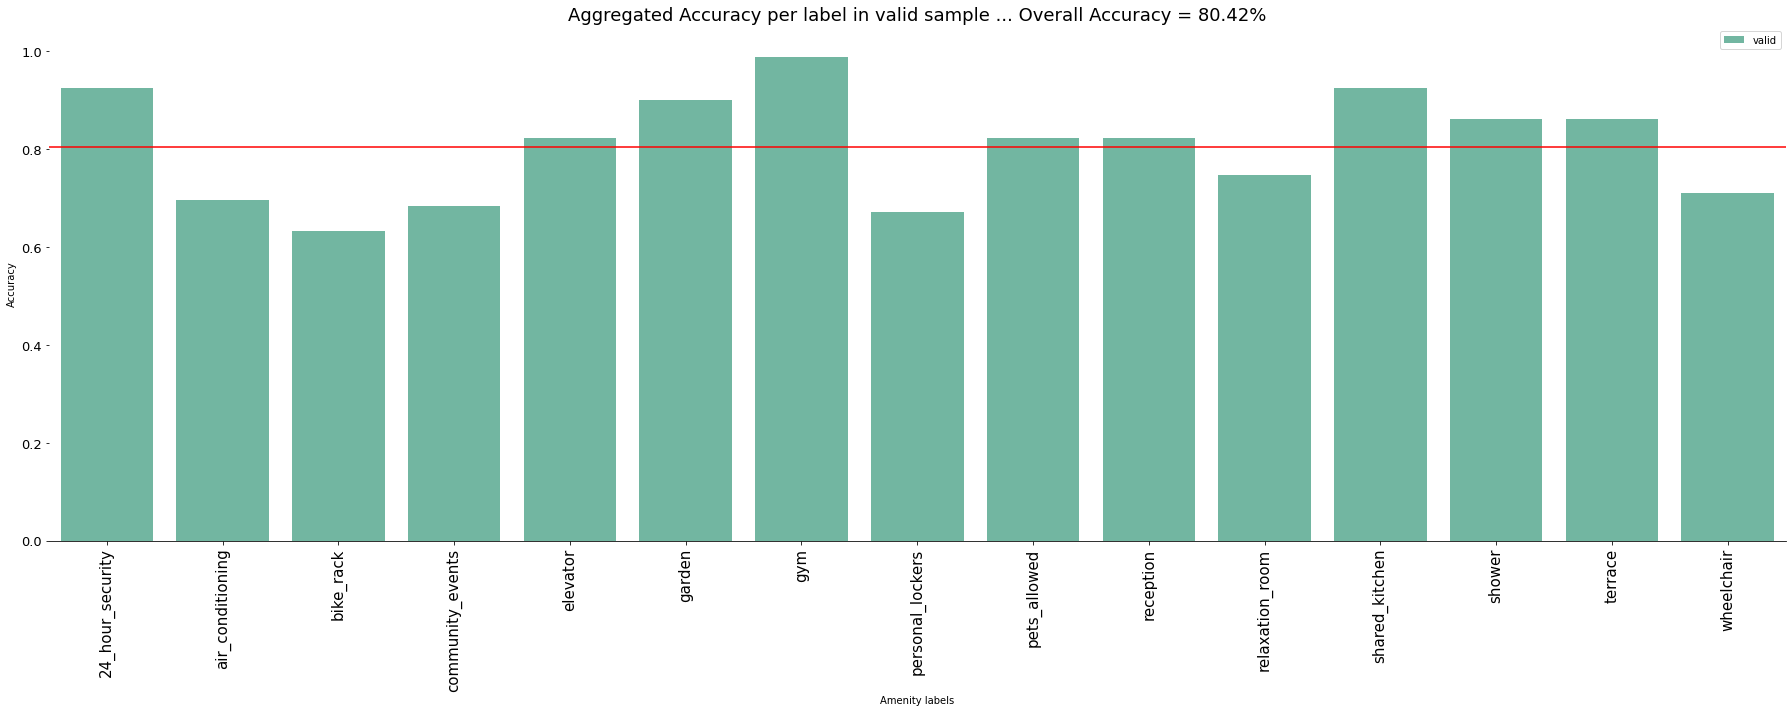

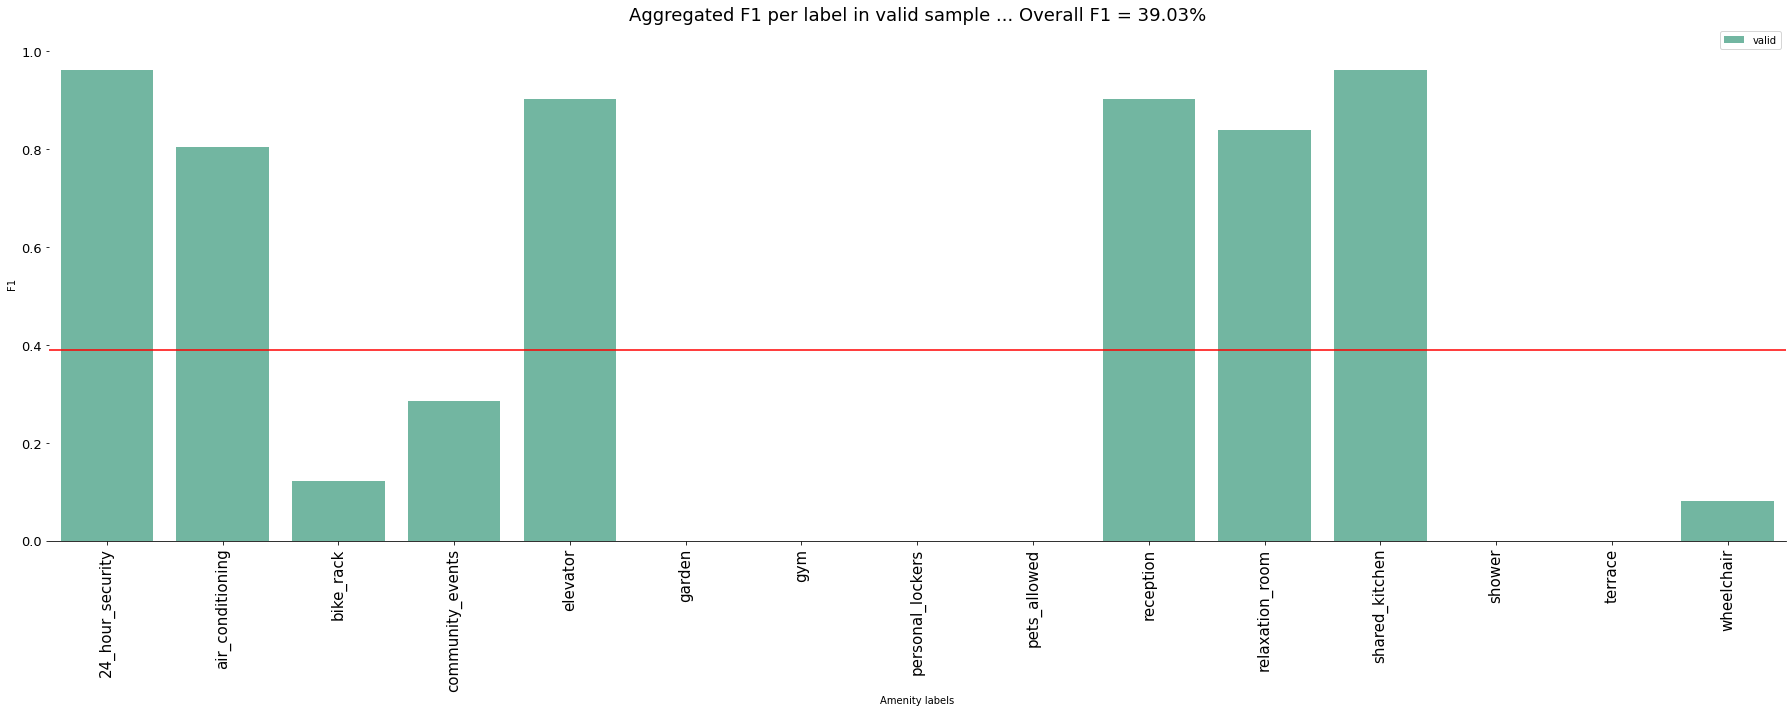

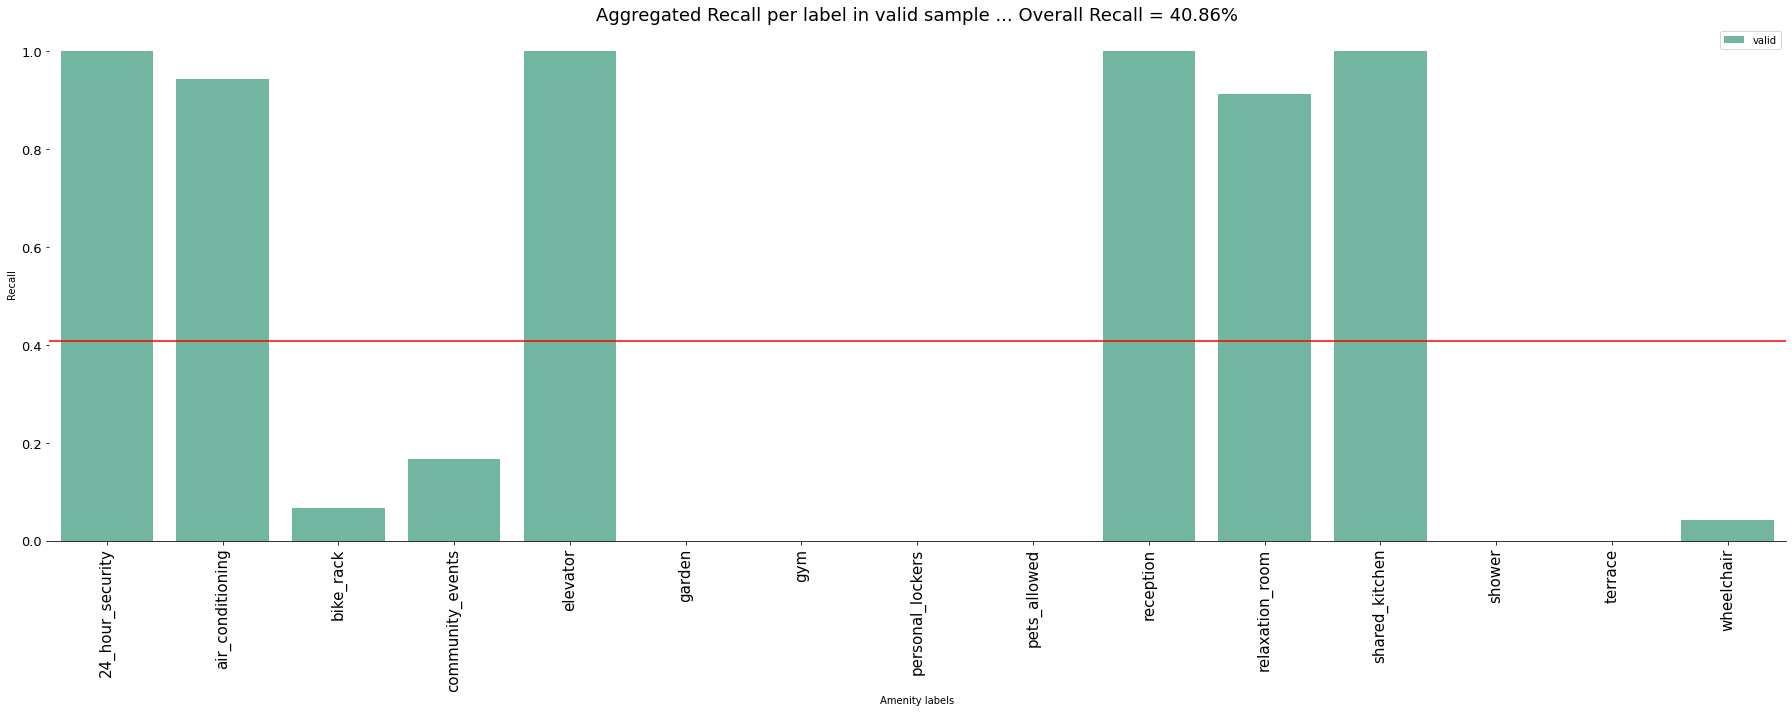

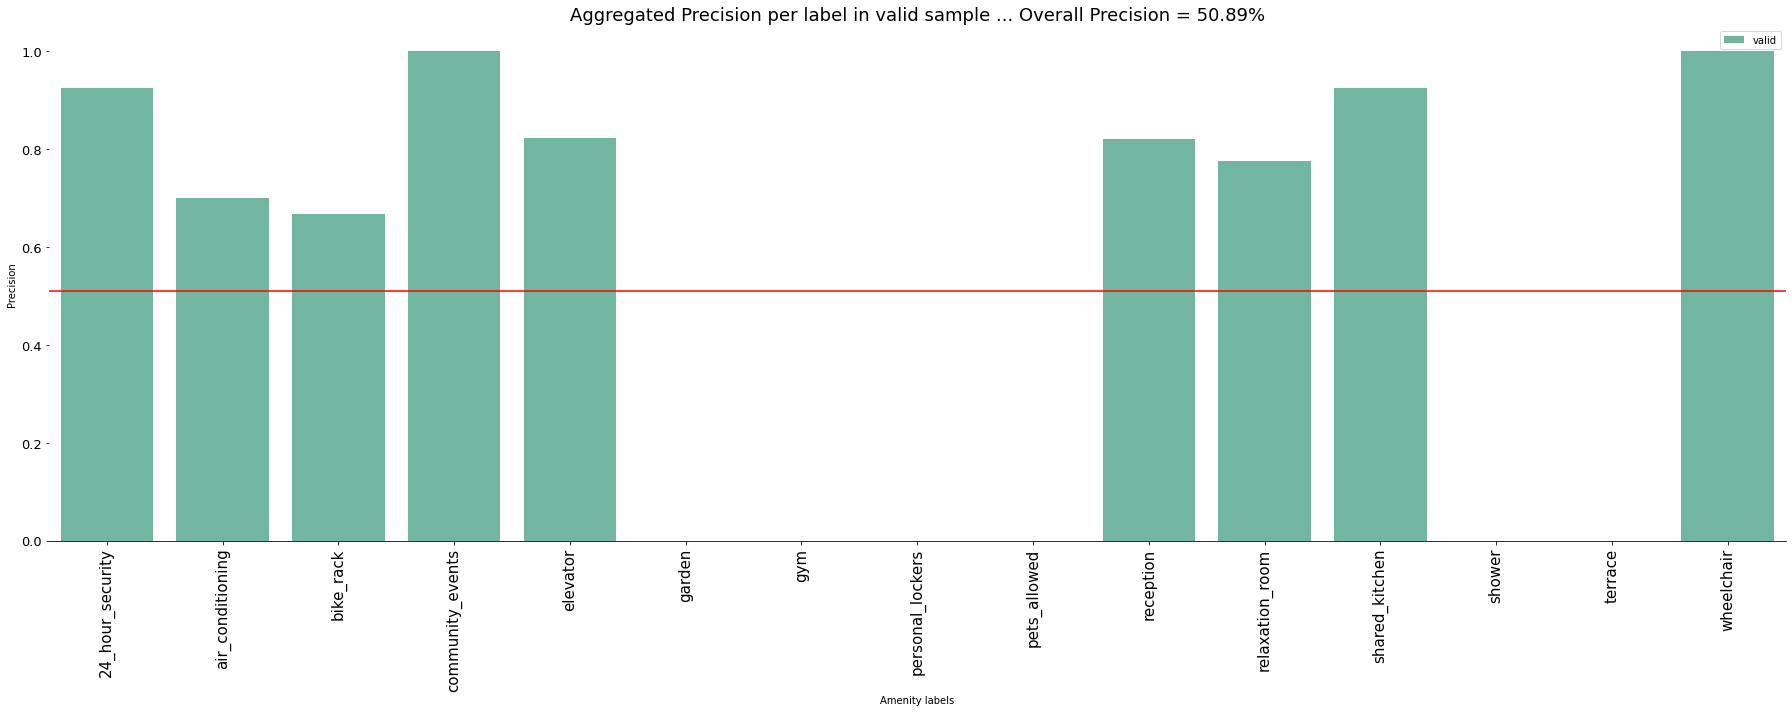

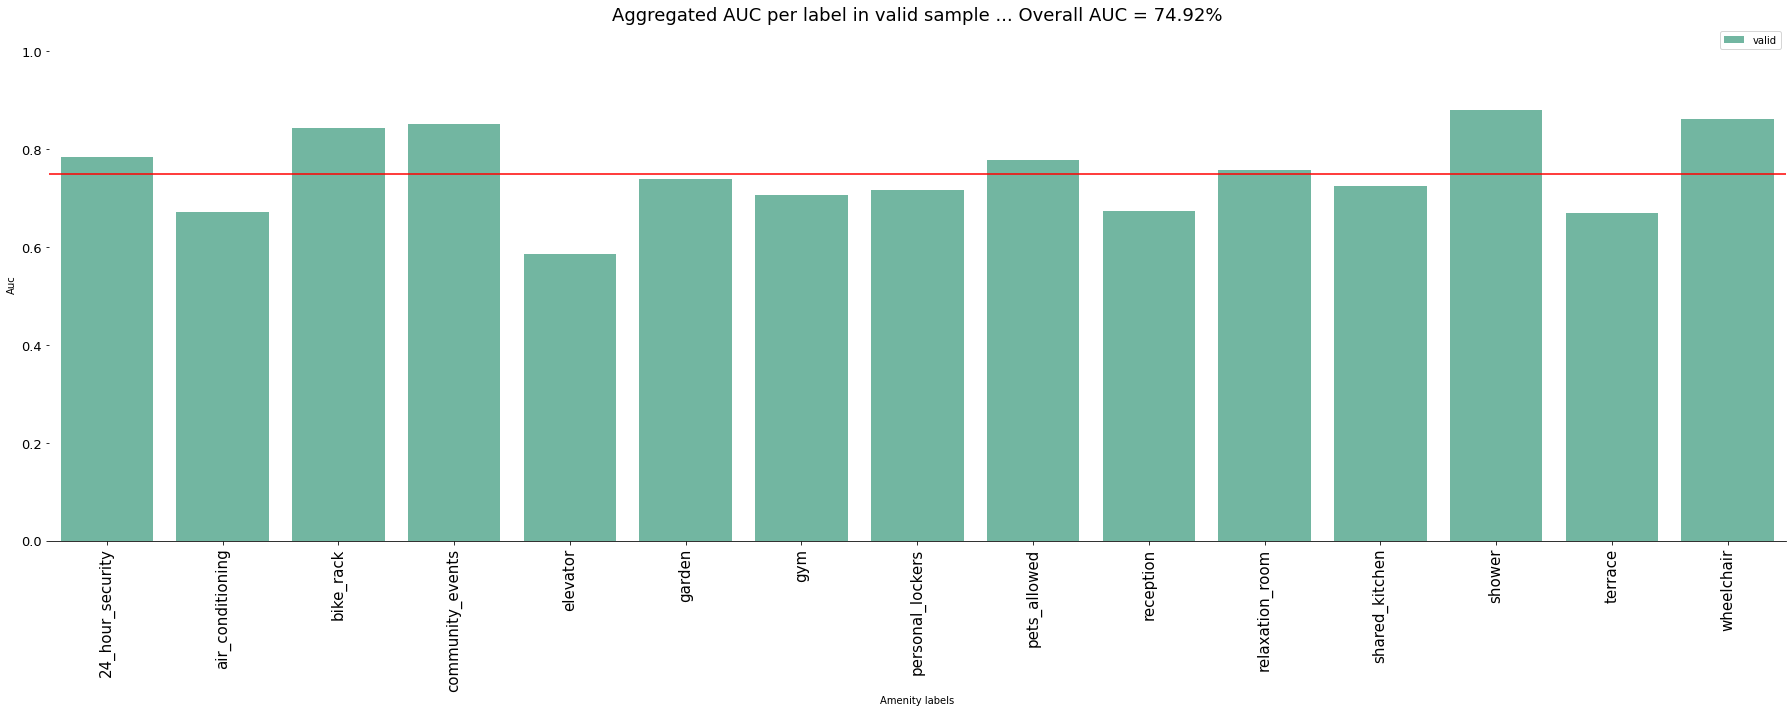

In [261]:
plot_overall_evaluation(valid_overall_ev_df, metrics_list, total = False, sample_name = 'valid')

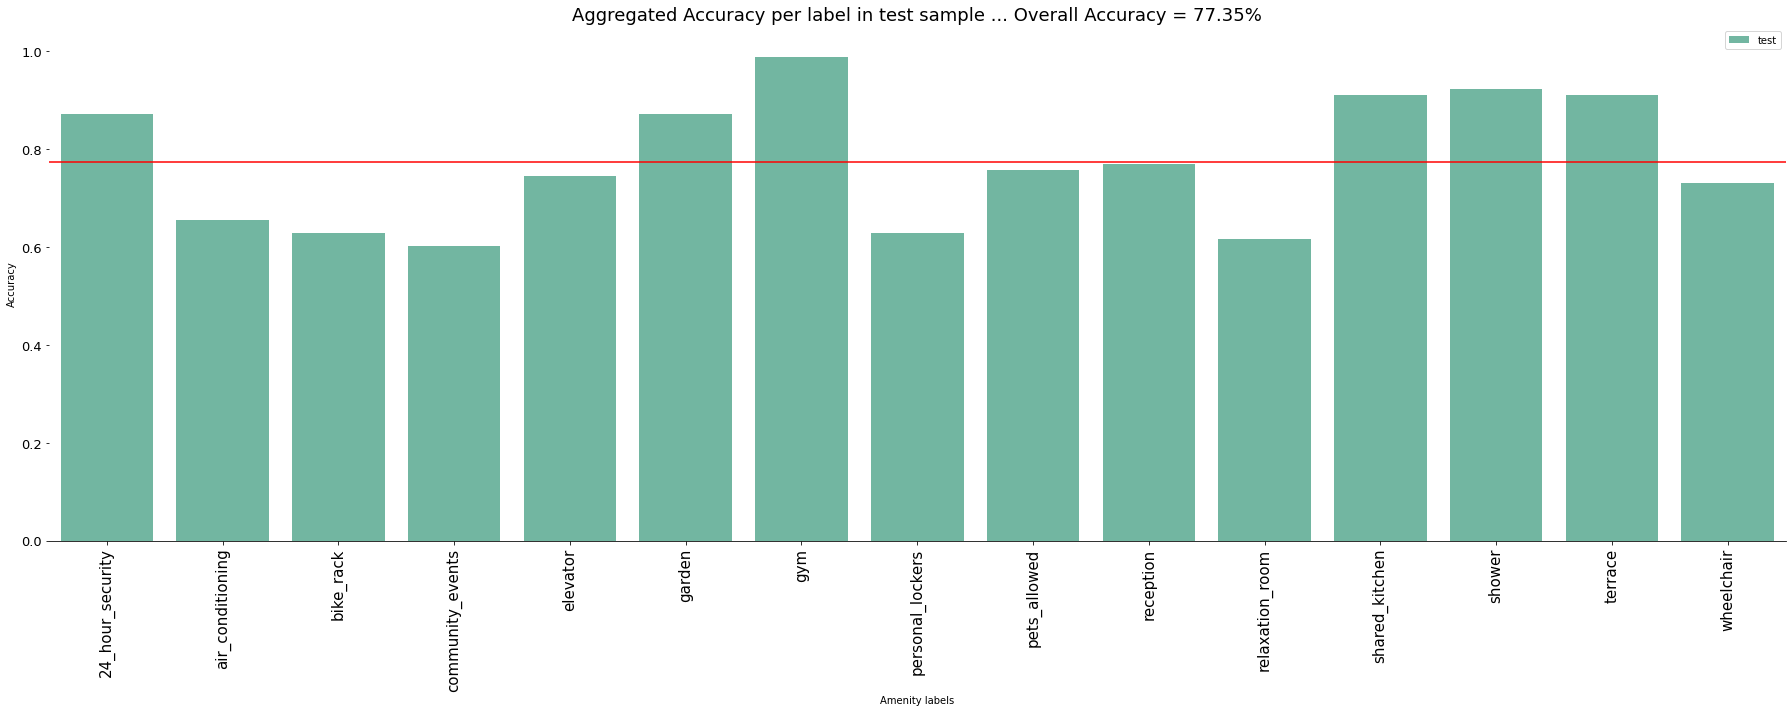

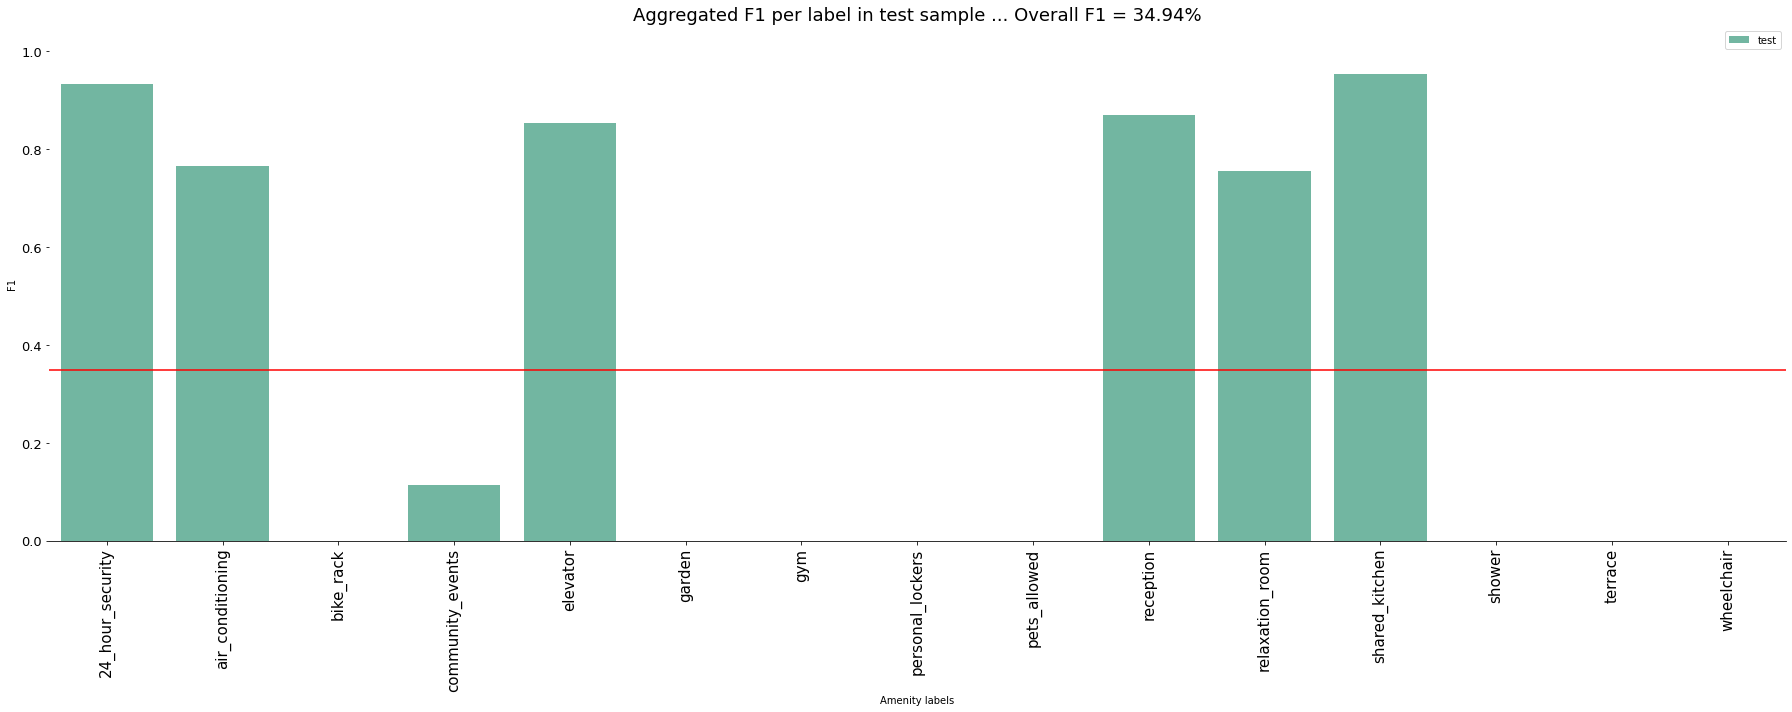

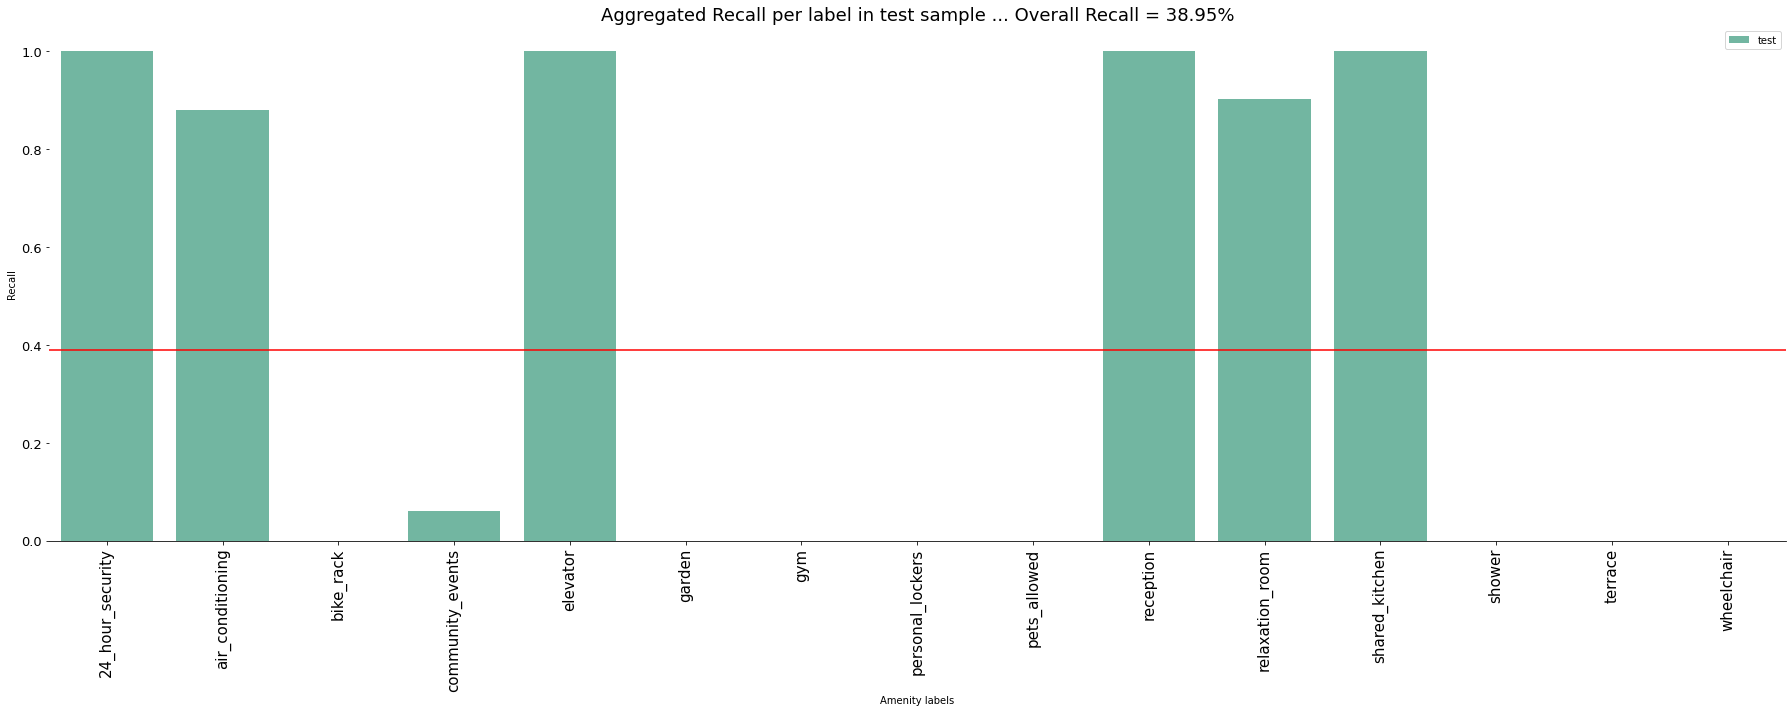

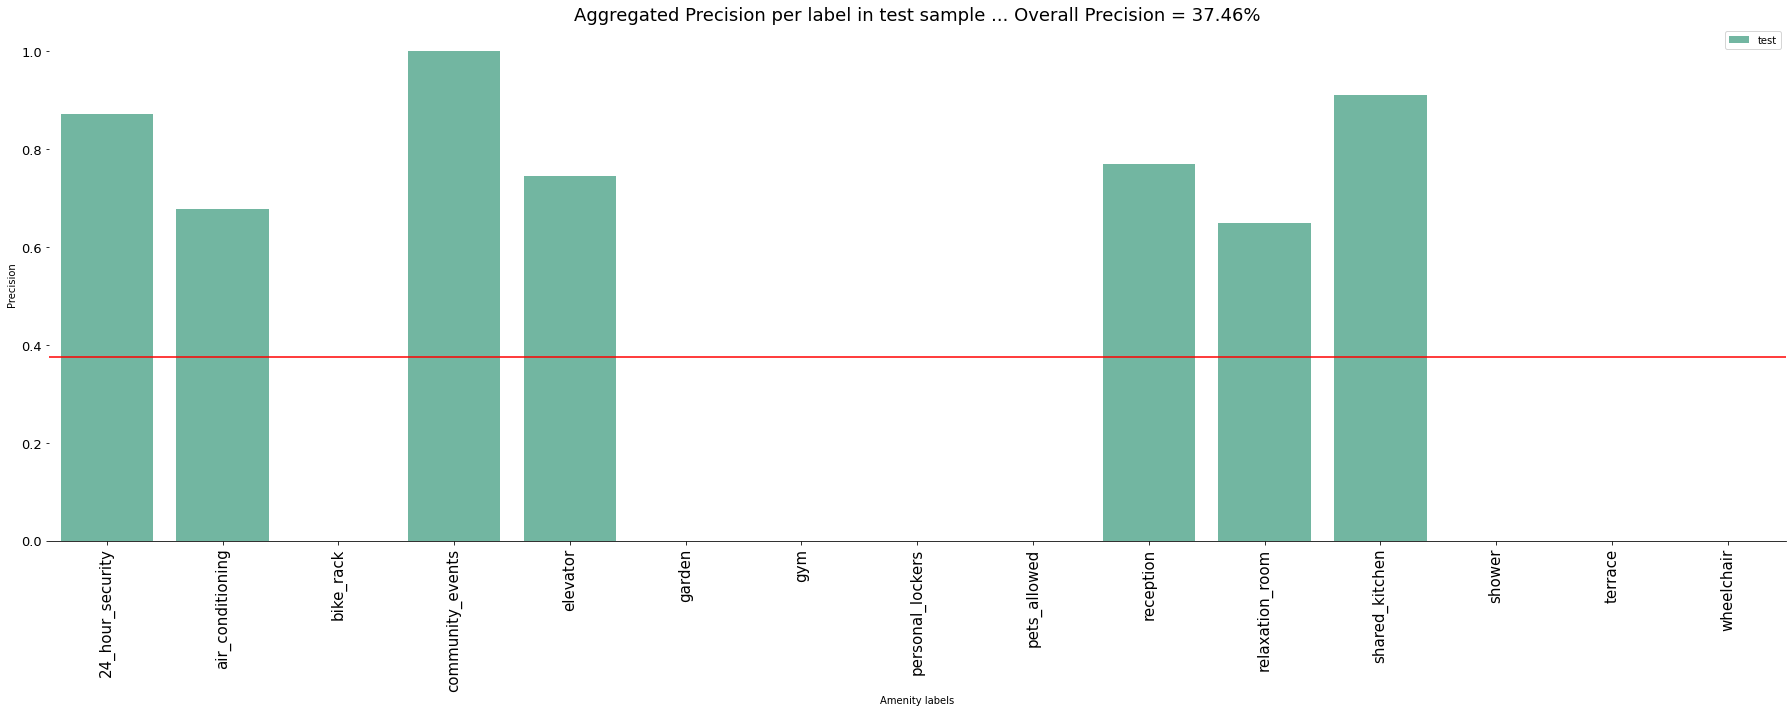

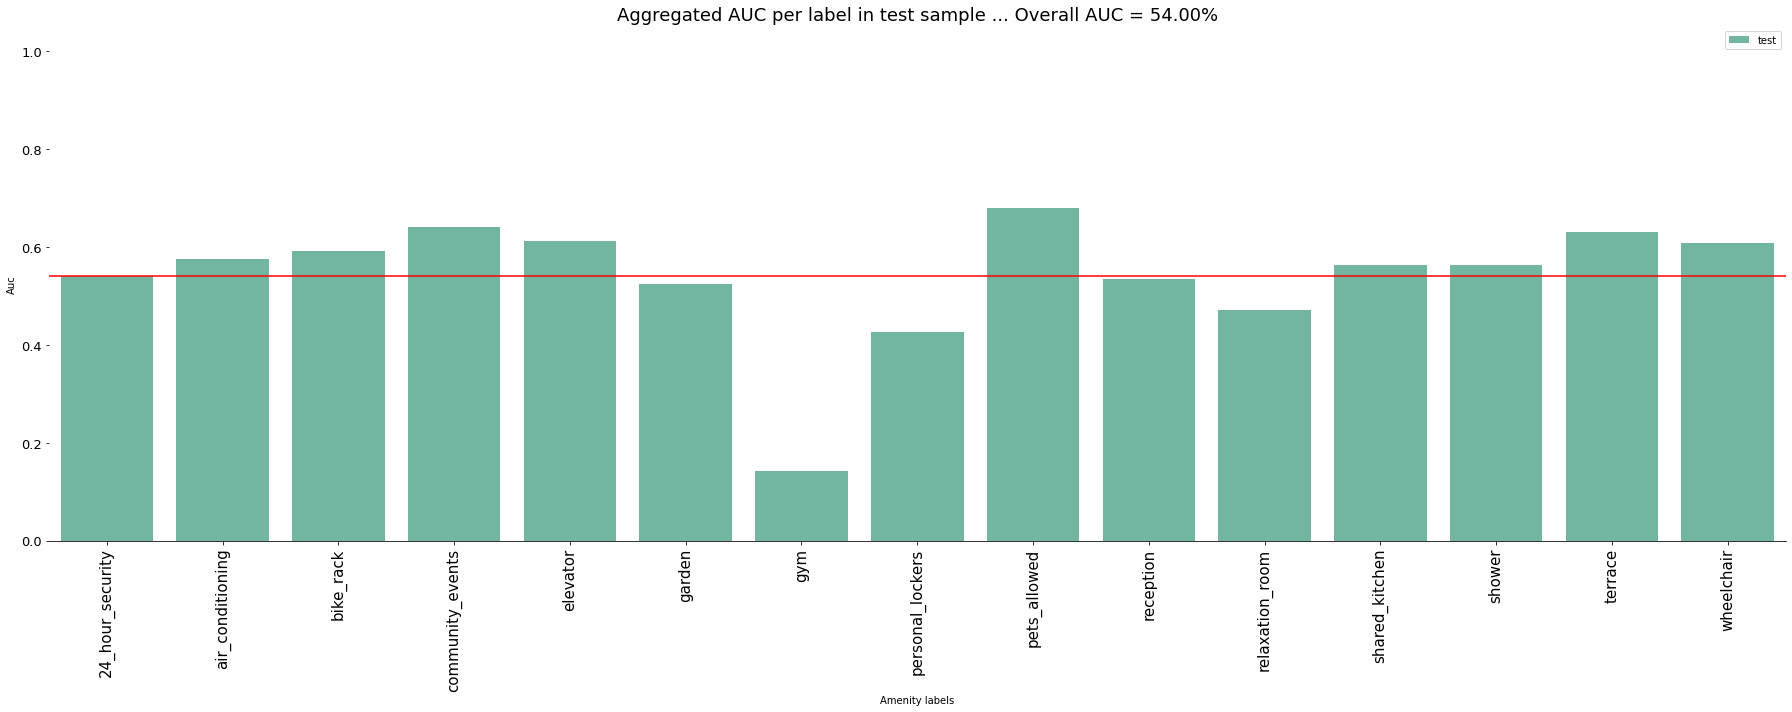

In [262]:
plot_overall_evaluation(test_overall_ev_df, metrics_list, total = False, sample_name = 'test')

Plotting the ROC curver per amenity label

In [287]:
def ROC_plot(predictions, df, num_pics, offices, label_names, sample_name = ''):

  sample_name = 'whole' if sample_name == '' else sample_name

  true_df = pd.DataFrame(columns = list(df.columns))

  for num, pic in zip(num_pics, offices):
    for i in range(num):
      true_row = df.query(f'location_id == {pic}')
      true_df = pd.concat((true_df, true_row))

  #data frame for storing predicted classes (occurences) based on probabilities.
  pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = label_names))

  #assigning the offices' names to each row.
  pred_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

  #aggregating the probabilities by the offices.
  pred_df = pred_df.groupby('location_id')[label_names].mean().reset_index()

  joined_df = pred_df.merge(df[df['location_id'].isin(offices)], on ='location_id', suffixes=('_pred','_true'))
  plt.figure(figsize = (13, 9))
  avg_auc = []
  for lab in label_names:
    fpr, tpr, _ = roc_curve(joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])
    auc = roc_auc_score(joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])
    avg_auc.append(auc)
    plt.plot(fpr,tpr,label=f"{lab}'s AUC = {auc*100:.2f}%",  linewidth=1)
  plt.plot([0, 1], [0, 1], 'r--',  linewidth=1)
  plt.ylabel('True Positive Rate', size = 10)
  plt.xlabel('False Positive Rate', size = 10)
  plt.title(f'ROC curves per amenity label on {sample_name} sample ... average AUC = {np.mean(avg_auc)*100:.2f}%', size = 15)
  plt.legend(bbox_to_anchor=(-0.07, 1.0), shadow = True, fontsize = 13)
  plt.grid()
  for spine in ['right', 'top']:
    mpl.rcParams[f'axes.spines.{spine}'] = False
  
  plt.tight_layout()
  if sample_name == 'whole':
    plt.savefig("plots/All_AUC_per_label.png")
  else:
    plt.savefig(f"plots/{str.capitalize(sample_name)}_AUC_per_label.png")
  plt.show()

In [288]:
all_predictions = np.concatenate((train_all_predictions, valid_all_predictions, test_all_predictions))
all_num_pics = train_num_pics + valid_num_pics + test_num_pics
all_offices = np.concatenate((train_offices, valid_offices, test_offices))

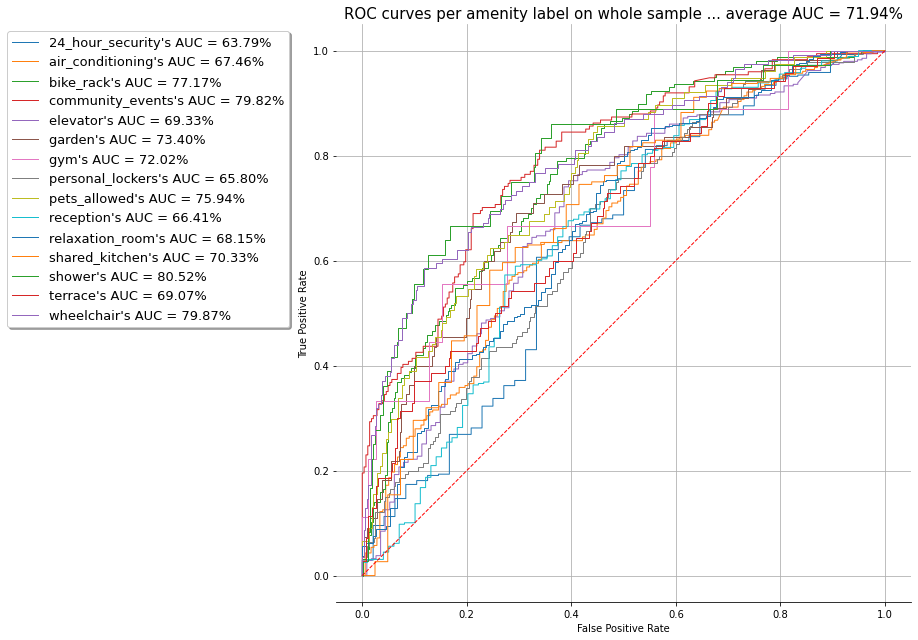

In [289]:
ROC_plot(all_predictions, df, all_num_pics, all_offices, label_names)

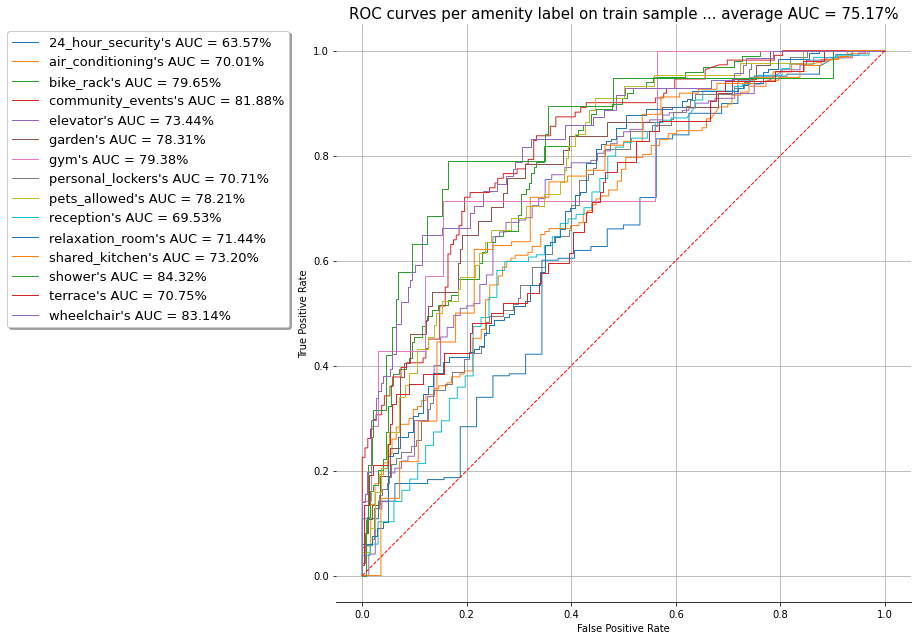

In [290]:
ROC_plot(train_all_predictions, df, train_num_pics, train_offices, label_names, sample_name = 'train')

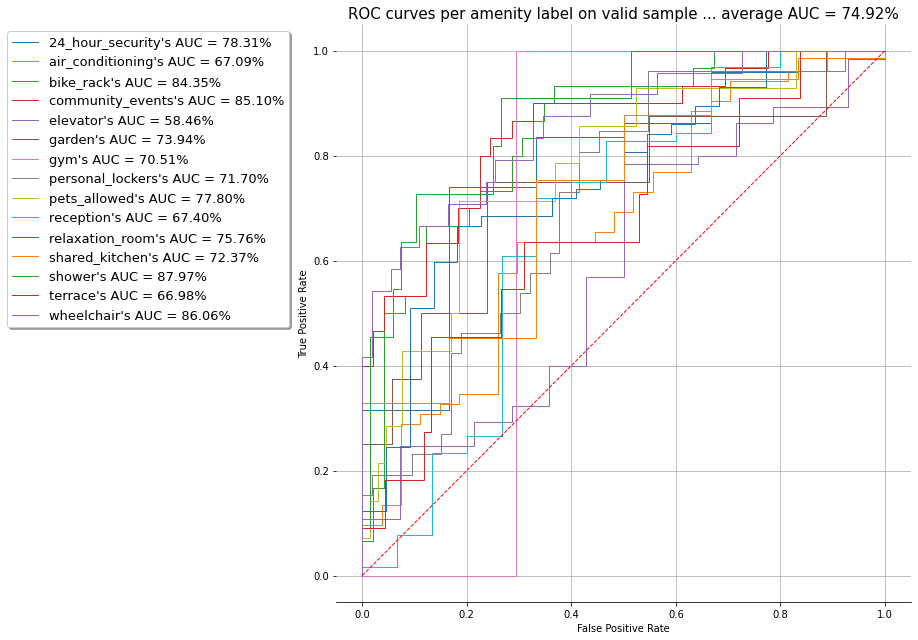

In [291]:
ROC_plot(valid_all_predictions, df, valid_num_pics, valid_offices, label_names, sample_name = 'valid')

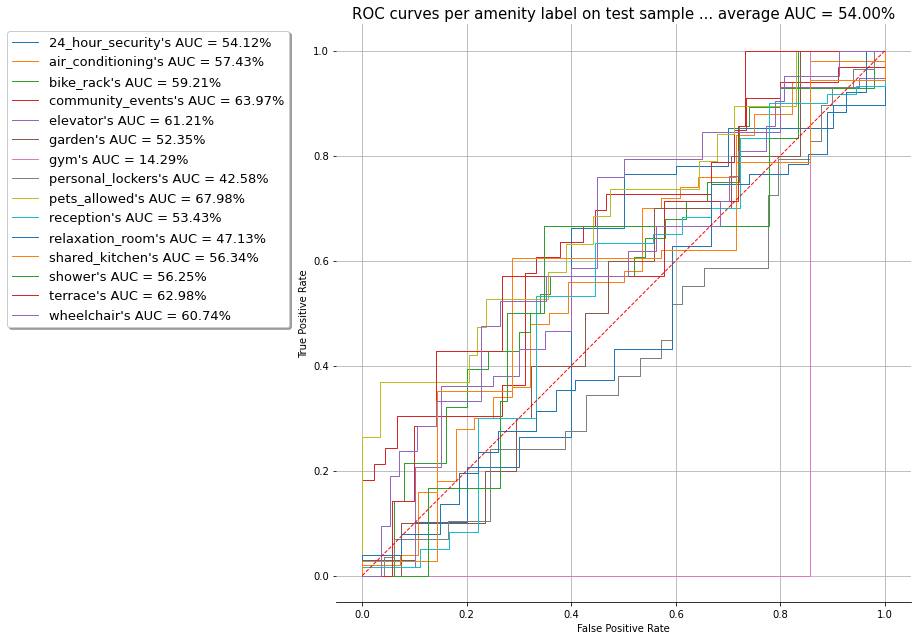

In [292]:
ROC_plot(test_all_predictions, df, test_num_pics, test_offices, label_names, sample_name = 'test')

##Amenities' list generator
- Based on predicted classes (occurrences), we predict a list of amenities which can be used for amenities' listing text generator in the further NLP dvelopment within the real-estate advertisement.

Data frame for storing the list of predicted amenities' occurrences per each office.

In [207]:
def preds_prop_listing(predictions, df, num_pics, offices, label_names):
    #data frame for storing predicted classes based on probabilities.

    #data frame for storing true classes.
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))
    
    #dataframe for storing predicted probabilities per class. 
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{c}_prob' for c in label_names]))

    joined_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    joined_df = joined_df.groupby('location_id')[[f'{c}_prob' for c in label_names]].mean().reset_index()

    for c in label_names:
      joined_df[c] = joined_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)

    pred_class_df = joined_df[[i for i in joined_df.columns if i.split('_')[-1] != 'prob']]
    
    #containing list of 1's and 0's indicating occurrence of given class.
    pred_class_df['class_indicators'] = pred_class_df.drop('location_id', axis = 1).values.tolist()

    #list for storing the occurred class names for each row.
    row_names_list = []

    #for each row find the class names which have occurred.
    for _, row in pred_class_df.iterrows():
      name_list = [] #list for storing occurred class names in given row.

      #for each class indicator and its name, find the occurred ones (1) and attached to list storing the occurred class names in given row.
      for num, name in zip(row['class_indicators'], label_names):
        if num == 1:
          name_list.append(name)

      #attach the list of occurred class names in given row to the list for storing list of class names for each row.
      row_names_list.append(str([','.join(name_list)]))

    #assigning the list to the data frame
    pred_class_df['label_names'] = [i.replace('[','').replace(']','').replace("'",'') for i in row_names_list]

    return pred_class_df[['location_id', 'label_names']]

In [208]:
train_preds_listing = preds_prop_listing(train_all_predictions, df, train_num_pics, train_offices, label_names)

In [209]:
valid_preds_listing = preds_prop_listing(valid_all_predictions, df, valid_num_pics, valid_offices, label_names)

In [210]:
test_preds_listing = preds_prop_listing(test_all_predictions, df, test_num_pics, test_offices, label_names)

In [211]:
display(train_preds_listing)

,location_id,label_names
0,2862,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,6617,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
2,6624,"24_hour_security,air_conditioning,elevator,reception,shared_kitchen"
3,11971,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
4,12218,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
295,89935,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
296,103037,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
297,103051,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
298,105300,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"


In [212]:
display(valid_preds_listing)

,location_id,label_names
0,11986,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,12217,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
2,12328,"24_hour_security,air_conditioning,elevator,reception,shared_kitchen"
3,13646,"24_hour_security,air_conditioning,elevator,reception,shared_kitchen"
4,14006,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
74,74924,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
75,83402,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
76,102908,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
77,105287,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"


In [213]:
display(test_preds_listing)

,location_id,label_names
0,6631,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
1,12329,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
2,12331,"24_hour_security,air_conditioning,elevator,reception,shared_kitchen"
3,12653,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
4,13554,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
73,72934,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
74,75720,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
75,79229,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
76,81509,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"


Visualazing the distribution of the predicted amenities' occurrences and the true amenities' occurrences

In [282]:
def plot_true_preds(preds_listing, df, sample_name = None):
  
  preds_df = pd.concat((preds_listing[['location_id']], preds_listing['label_names'].str.get_dummies(',')), axis = 1)
  true_df = df[df['location_id'].isin(preds_df['location_id'])].copy().reset_index(drop = True)

  for col in true_df.columns:
    if col not in preds_df.columns:
      preds_df[col] = 0

  preds_df.columns = true_df.columns

  df_list = []

  for d, name in zip([true_df, preds_df], ['true labels', 'predicted labels']):
      d.drop('location_id', axis = 1, inplace = True)

      temp_df = d.sum().reset_index().rename(columns = {'index':'class', 0:'count'})
      temp_df['label_type'] = name

      df_list.append(temp_df)

  final_df = pd.concat((df_list[0], df_list[1]))

  title = 'whole' if sample_name == None else sample_name

  plt.figure(figsize = (20, 10))
  sns.barplot(data = final_df, x ='class', y = 'count', hue = 'label_type', palette = 'Set2')
  plt.xticks(rotation = 90, size = 15)

  plt.title(f'Distribution of predicted and true classes on the {title} sample', size = 18)
  plt.tight_layout()
  plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize = 12)
  if title == 'whole':
    plt.savefig('All_Distribution_Pred_True.png')
  else:
    plt.savefig(f'plots/{str.capitalize(title)}_Distribution_Pred_True.png')
  plt.show()

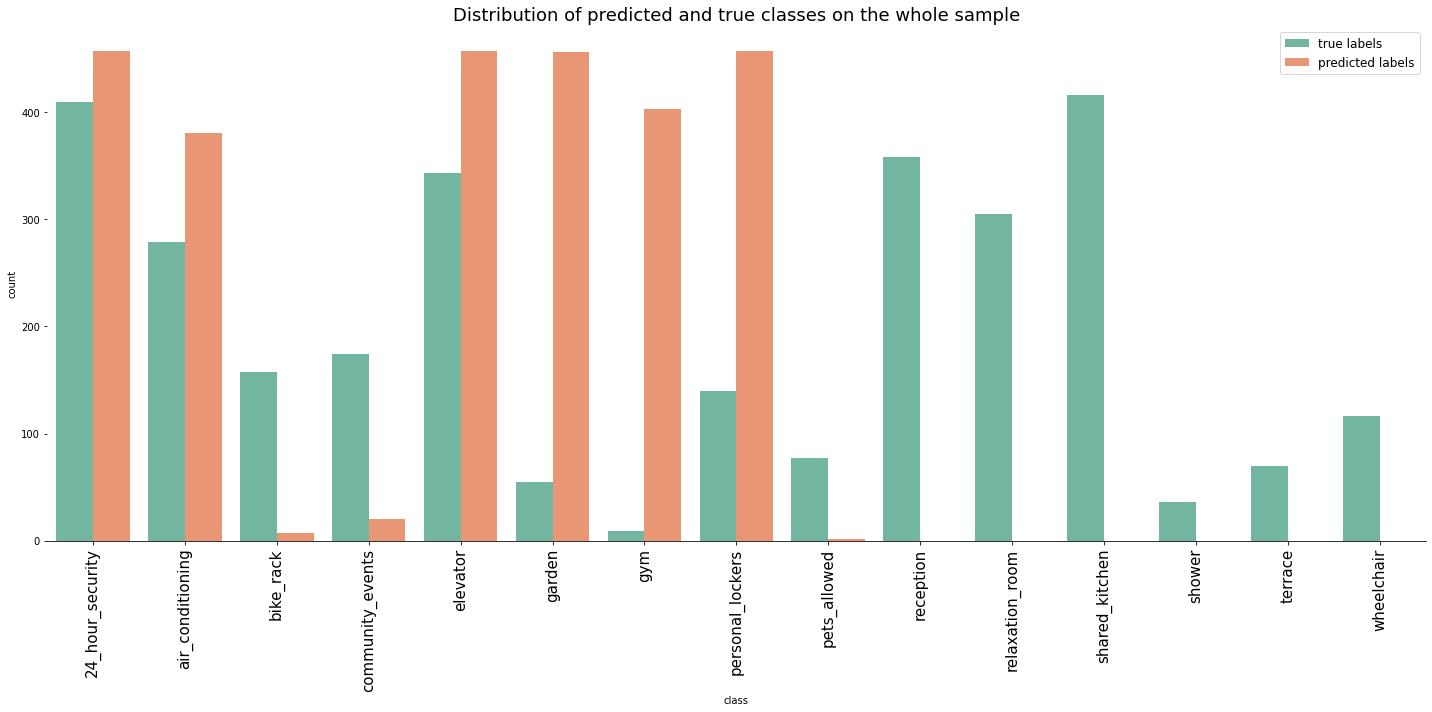

In [283]:
plot_true_preds(pd.concat((train_preds_listing, valid_preds_listing, test_preds_listing)), df)

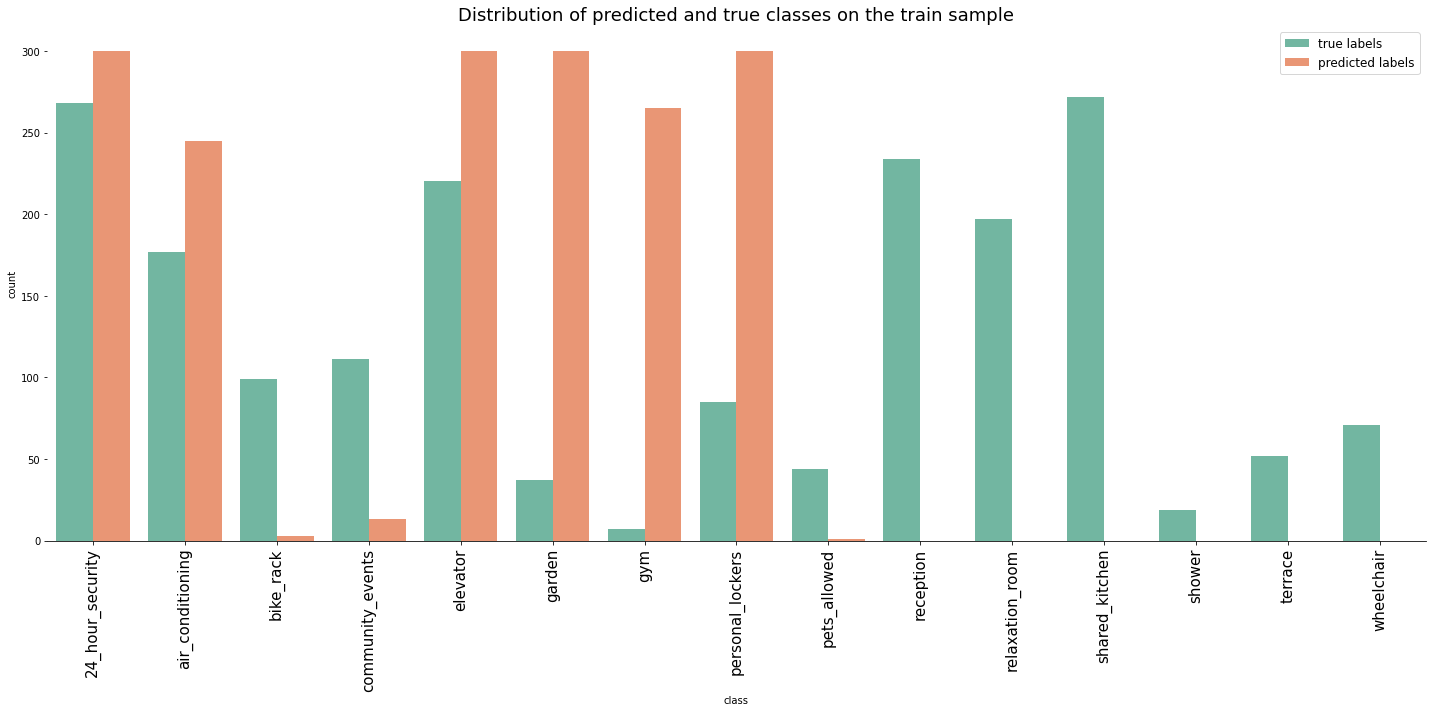

In [284]:
plot_true_preds(train_preds_listing, df, sample_name = 'train')

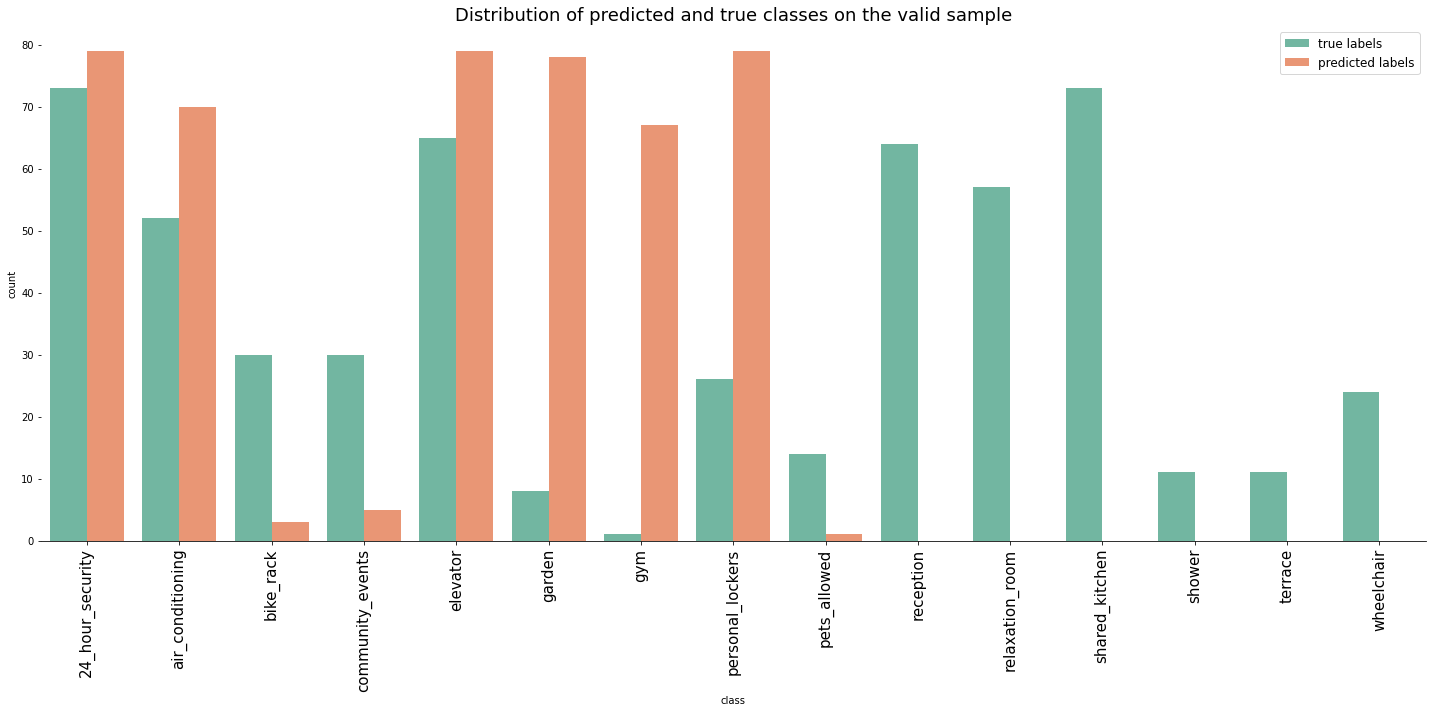

In [285]:
plot_true_preds(valid_preds_listing, df, sample_name = 'valid')

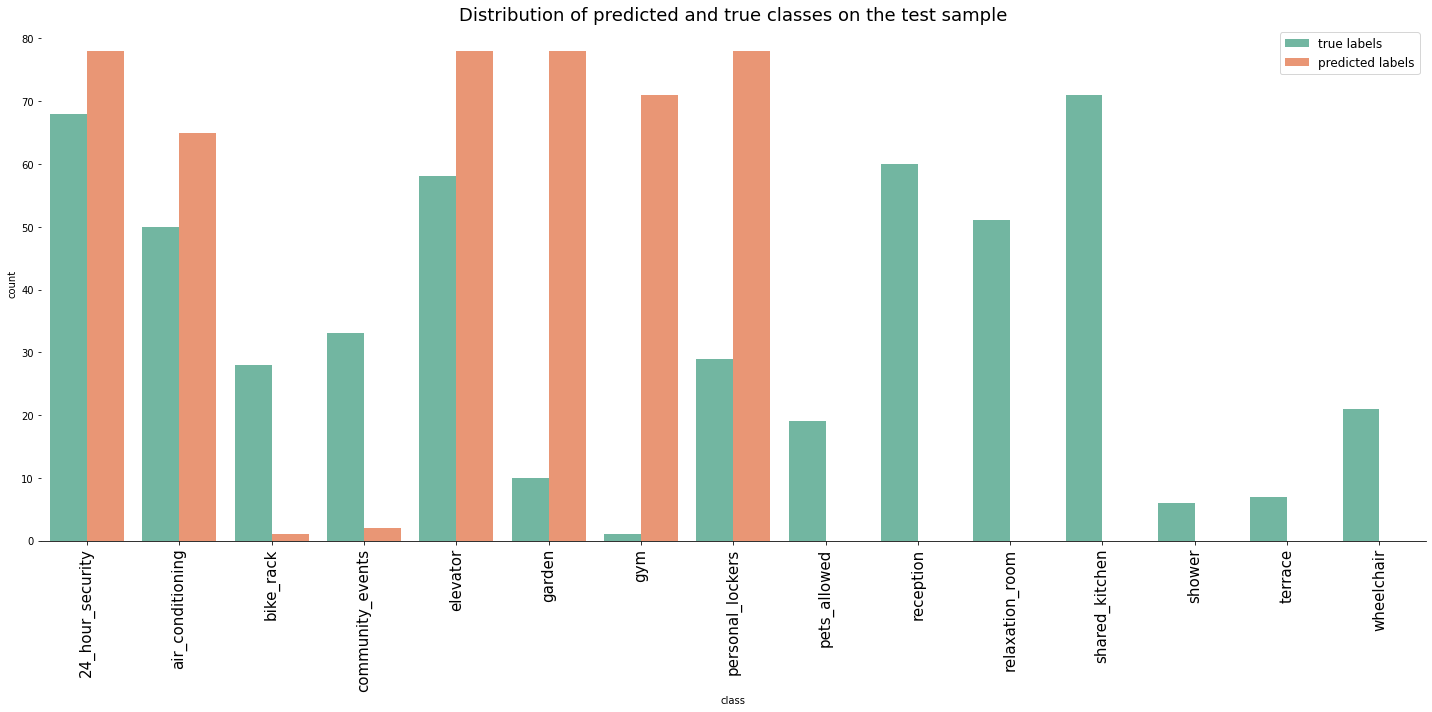

In [286]:
plot_true_preds(test_preds_listing, df, sample_name = 'test')

**Further recommendations:**
- *Better quality of photos with higher resolution*
- *Photos' selection - including only relevant photos (we don't want model training on non-relevant photos such as photo of a building from the outsice etc.)
- Considering better definiton of amenity labels which can be observed from the photos.